In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
import json
from datetime import datetime
warnings.filterwarnings('ignore')

In [3]:
# Cell 2: Configuration
REGIONS = ['delhi', 'kolkata']
MEDICINES = {
    'delhi': ['paracetamol', 'ibuprofen', 'amoxicillin', 'cetirizine', 'salbutamol'],
    'kolkata': ['paracetamol', 'ibuprofen', 'amoxicillin', 'loperamide', 'metronidazole']
}

FESTIVAL_DATES = {
    'delhi': [
        '2020-10-25', '2021-11-04', '2022-10-24', '2023-11-12',  # Diwali
        '2020-08-03', '2021-08-22', '2022-08-11', '2023-08-30'   # Raksha Bandhan
    ],
    'kolkata': [
        '2020-10-25', '2021-11-04', '2022-10-24', '2023-11-12',  # Diwali
        '2020-10-22', '2021-10-15', '2022-10-05', '2023-10-24'   # Durga Puja
    ]
}

In [4]:
# Cell 3: Data Loading Functions
def load_data(region: str, medicine: str) -> pd.DataFrame:
    """Load and prepare data for Prophet"""
    file_path = Path(f"../../dataset/data/{region}/processed/{medicine}_prophet.csv")
    df = pd.read_csv(file_path)
    df['ds'] = pd.to_datetime(df['ds'])
    return df

def create_events_df(start_date: pd.Timestamp, end_date: pd.Timestamp, region: str) -> pd.DataFrame:
    """Create events dataframe with festival dates"""
    date_range = pd.date_range(start=start_date, end=end_date + pd.Timedelta(days=90))
    events_df = pd.DataFrame({'ds': date_range})
    events_df['special_event'] = 0
    
    # Mark festival dates
    festival_dates = pd.to_datetime(FESTIVAL_DATES[region])
    events_df.loc[events_df['ds'].isin(festival_dates), 'special_event'] = 1
    
    return events_df

In [5]:
# Cell 4: Model Training and Tuning Functions
def tune_prophet_hyperparameters(df: pd.DataFrame, events_df: pd.DataFrame = None) -> tuple:
    """Tune Prophet hyperparameters using grid search"""
    param_grid = {
        'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'seasonality_mode': ['multiplicative', 'additive']
    }
    
    best_params = {}
    best_rmse = float('inf')
    
    for cp in param_grid['changepoint_prior_scale']:
        for sp in param_grid['seasonality_prior_scale']:
            for sm in param_grid['seasonality_mode']:
                params = {
                    'changepoint_prior_scale': cp,
                    'seasonality_prior_scale': sp,
                    'seasonality_mode': sm,
                    'yearly_seasonality': True,
                    'weekly_seasonality': True,
                    'daily_seasonality': False
                }
                
                model = Prophet(**params)
                
                if events_df is not None:
                    df_with_events = df.merge(events_df, on='ds', how='left')
                    df_with_events['special_event'] = df_with_events['special_event'].fillna(0)
                    model.add_regressor('special_event', mode='multiplicative')
                    model.fit(df_with_events)
                else:
                    model.fit(df)
                
                # Cross validation
                df_cv = cross_validation(model, initial='365 days', period='90 days', horizon='90 days')
                df_p = performance_metrics(df_cv)
                rmse = df_p['rmse'].mean()
                
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = params
                
                print(f"Parameters: {params}")
                print(f"RMSE: {rmse:.2f}")
                print("---")
    
    return best_params, best_rmse

def train_model(df: pd.DataFrame, params: dict, events_df: pd.DataFrame = None) -> Prophet:
    """Train Prophet model with given parameters"""
    model = Prophet(**params)
    
    if events_df is not None:
        df_with_events = df.merge(events_df, on='ds', how='left')
        df_with_events['special_event'] = df_with_events['special_event'].fillna(0)
        model.add_regressor('special_event', mode='multiplicative')
        model.fit(df_with_events)
    else:
        model.fit(df)
    
    return model

In [6]:
# Cell 5: Evaluation Functions
def evaluate_model(y_true: np.array, y_pred: np.array) -> dict:
    """Calculate model evaluation metrics"""
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape
    }

In [7]:
# Cell 6: Visualization Functions
def plot_forecast(model: Prophet, forecast: pd.DataFrame, title: str):
    """Plot forecast with components"""
    fig = model.plot(forecast)
    plt.title(f'{title} - Forecast')
    plt.show()
    
    fig = model.plot_components(forecast)
    plt.suptitle(f'{title} - Components')
    plt.tight_layout()
    plt.show()


In [8]:
# Cell 7: Main Training Loop - Start with Paracetamol
def train_single_medicine(region: str, medicine: str, include_events: bool = True) -> dict:
    """Train and evaluate model for a single medicine in a region"""
    print(f"\nTraining model for {medicine} in {region}")
    
    # Load data
    df = load_data(region, medicine)
    
    # Create events dataframe if needed
    events_df = None
    if include_events:
        events_df = create_events_df(df['ds'].min(), df['ds'].max(), region)
    
    # Tune hyperparameters
    print("\nTuning hyperparameters...")
    best_params, best_rmse = tune_prophet_hyperparameters(df, events_df)
    print(f"\nBest parameters: {best_params}")
    print(f"Best RMSE: {best_rmse:.2f}")
    
    # Train final model
    print("\nTraining final model...")
    model = train_model(df, best_params, events_df)
    
    # Generate forecast
    future = model.make_future_dataframe(periods=90)
    if events_df is not None:
        future = future.merge(events_df, on='ds', how='left')
        future['special_event'] = future['special_event'].fillna(0)
    
    forecast = model.predict(future)
    
    # Evaluate model
    metrics = evaluate_model(
        df['y'].values,
        forecast['yhat'][:len(df)]
    )
    
    # Plot results
    plot_forecast(model, forecast, f"{region.title()} - {medicine.title()}")
    
    return {
        'model': model,
        'forecast': forecast,
        'metrics': metrics,
        'params': best_params
    }



Training model for paracetamol in delhi

Tuning hyperparameters...


05:28:45 - cmdstanpy - INFO - Chain [1] start processing
05:28:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:28:45 - cmdstanpy - INFO - Chain [1] start processing
05:28:45 - cmdstanpy - INFO - Chain [1] done processing
05:28:45 - cmdstanpy - INFO - Chain [1] start processing
05:28:45 - cmdstanpy - INFO - Chain [1] done processing
05:28:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:28:45 - cmdstanpy - INFO - Chain [1] start processing
05:28:45 - cmdstanpy - INFO - Chain [1] done processing
05:28:45 - cmdstanpy - INFO - Chain [1] start processing
05:28:45 - cmdstanpy - INFO - Chain [1] done processing
05:28:46 - cmdstanpy - INFO - Chain [1] start processing
05:28:46 - cmdstanpy - INFO - Chain [1] done processing
05:28:46 - cmdstanpy - INFO - Chain [1] start processing
05:28:46 - cmdstanpy - INFO - Chain [1] done processing
05:28:46 - cmdstanpy - INFO - Chain [1] start processing
05:28:46 - cmdstanpy - INFO - Chain [1] done processing
05:28:46 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.66
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:28:47 - cmdstanpy - INFO - Chain [1] start processing
05:28:47 - cmdstanpy - INFO - Chain [1] done processing
05:28:48 - cmdstanpy - INFO - Chain [1] start processing
05:28:48 - cmdstanpy - INFO - Chain [1] done processing
05:28:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:28:48 - cmdstanpy - INFO - Chain [1] start processing
05:28:48 - cmdstanpy - INFO - Chain [1] done processing
05:28:48 - cmdstanpy - INFO - Chain [1] start processing
05:28:48 - cmdstanpy - INFO - Chain [1] done processing
05:28:48 - cmdstanpy - INFO - Chain [1] start processing
05:28:48 - cmdstanpy - INFO - Chain [1] done processing
05:28:49 - cmdstanpy - INFO - Chain [1] start processing
05:28:49 - cmdstanpy - INFO - Chain [1] done processing
05:28:49 - cmdstanpy - INFO - Chain [1] start processing
05:28:49 - cmdstanpy - INFO - Chain [1] done processing
05:28:49 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.76
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:28:50 - cmdstanpy - INFO - Chain [1] start processing
05:28:50 - cmdstanpy - INFO - Chain [1] done processing
05:28:50 - cmdstanpy - INFO - Chain [1] start processing
05:28:50 - cmdstanpy - INFO - Chain [1] done processing
05:28:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:28:50 - cmdstanpy - INFO - Chain [1] start processing
05:28:51 - cmdstanpy - INFO - Chain [1] done processing
05:28:51 - cmdstanpy - INFO - Chain [1] start processing
05:28:51 - cmdstanpy - INFO - Chain [1] done processing
05:28:51 - cmdstanpy - INFO - Chain [1] start processing
05:28:51 - cmdstanpy - INFO - Chain [1] done processing
05:28:51 - cmdstanpy - INFO - Chain [1] start processing
05:28:51 - cmdstanpy - INFO - Chain [1] done processing
05:28:51 - cmdstanpy - INFO - Chain [1] start processing
05:28:51 - cmdstanpy - INFO - Chain [1] done processing
05:28:52 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.42
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:28:53 - cmdstanpy - INFO - Chain [1] start processing
05:28:53 - cmdstanpy - INFO - Chain [1] done processing
05:28:53 - cmdstanpy - INFO - Chain [1] start processing
05:28:53 - cmdstanpy - INFO - Chain [1] done processing
05:28:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:28:53 - cmdstanpy - INFO - Chain [1] start processing
05:28:53 - cmdstanpy - INFO - Chain [1] done processing
05:28:54 - cmdstanpy - INFO - Chain [1] start processing
05:28:54 - cmdstanpy - INFO - Chain [1] done processing
05:28:54 - cmdstanpy - INFO - Chain [1] start processing
05:28:54 - cmdstanpy - INFO - Chain [1] done processing
05:28:54 - cmdstanpy - INFO - Chain [1] start processing
05:28:54 - cmdstanpy - INFO - Chain [1] done processing
05:28:54 - cmdstanpy - INFO - Chain [1] start processing
05:28:54 - cmdstanpy - INFO - Chain [1] done processing
05:28:54 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 33.06
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:28:55 - cmdstanpy - INFO - Chain [1] start processing
05:28:55 - cmdstanpy - INFO - Chain [1] done processing
05:28:56 - cmdstanpy - INFO - Chain [1] start processing
05:28:56 - cmdstanpy - INFO - Chain [1] done processing
05:28:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:28:56 - cmdstanpy - INFO - Chain [1] start processing
05:28:56 - cmdstanpy - INFO - Chain [1] done processing
05:28:56 - cmdstanpy - INFO - Chain [1] start processing
05:28:56 - cmdstanpy - INFO - Chain [1] done processing
05:28:56 - cmdstanpy - INFO - Chain [1] start processing
05:28:56 - cmdstanpy - INFO - Chain [1] done processing
05:28:56 - cmdstanpy - INFO - Chain [1] start processing
05:28:57 - cmdstanpy - INFO - Chain [1] done processing
05:28:57 - cmdstanpy - INFO - Chain [1] start processing
05:28:57 - cmdstanpy - INFO - Chain [1] done processing
05:28:57 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.28
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:28:58 - cmdstanpy - INFO - Chain [1] start processing
05:28:58 - cmdstanpy - INFO - Chain [1] done processing
05:28:58 - cmdstanpy - INFO - Chain [1] start processing
05:28:58 - cmdstanpy - INFO - Chain [1] done processing
05:28:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:28:58 - cmdstanpy - INFO - Chain [1] start processing
05:28:59 - cmdstanpy - INFO - Chain [1] done processing
05:28:59 - cmdstanpy - INFO - Chain [1] start processing
05:28:59 - cmdstanpy - INFO - Chain [1] done processing
05:28:59 - cmdstanpy - INFO - Chain [1] start processing
05:28:59 - cmdstanpy - INFO - Chain [1] done processing
05:28:59 - cmdstanpy - INFO - Chain [1] start processing
05:28:59 - cmdstanpy - INFO - Chain [1] done processing
05:28:59 - cmdstanpy - INFO - Chain [1] start processing
05:28:59 - cmdstanpy - INFO - Chain [1] done processing
05:28:59 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 33.58
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:01 - cmdstanpy - INFO - Chain [1] start processing
05:29:01 - cmdstanpy - INFO - Chain [1] done processing
05:29:01 - cmdstanpy - INFO - Chain [1] start processing
05:29:01 - cmdstanpy - INFO - Chain [1] done processing
05:29:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:29:01 - cmdstanpy - INFO - Chain [1] start processing
05:29:02 - cmdstanpy - INFO - Chain [1] done processing
05:29:02 - cmdstanpy - INFO - Chain [1] start processing
05:29:02 - cmdstanpy - INFO - Chain [1] done processing
05:29:02 - cmdstanpy - INFO - Chain [1] start processing
05:29:02 - cmdstanpy - INFO - Chain [1] done processing
05:29:02 - cmdstanpy - INFO - Chain [1] start processing
05:29:02 - cmdstanpy - INFO - Chain [1] done processing
05:29:02 - cmdstanpy - INFO - Chain [1] start processing
05:29:02 - cmdstanpy - INFO - Chain [1] done processing
05:29:02 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.80
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:04 - cmdstanpy - INFO - Chain [1] start processing
05:29:04 - cmdstanpy - INFO - Chain [1] done processing
05:29:04 - cmdstanpy - INFO - Chain [1] start processing
05:29:04 - cmdstanpy - INFO - Chain [1] done processing
05:29:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:29:04 - cmdstanpy - INFO - Chain [1] start processing
05:29:04 - cmdstanpy - INFO - Chain [1] done processing
05:29:04 - cmdstanpy - INFO - Chain [1] start processing
05:29:04 - cmdstanpy - INFO - Chain [1] done processing
05:29:04 - cmdstanpy - INFO - Chain [1] start processing
05:29:05 - cmdstanpy - INFO - Chain [1] done processing
05:29:05 - cmdstanpy - INFO - Chain [1] start processing
05:29:05 - cmdstanpy - INFO - Chain [1] done processing
05:29:05 - cmdstanpy - INFO - Chain [1] start processing
05:29:05 - cmdstanpy - INFO - Chain [1] done processing
05:29:05 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 33.42
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:06 - cmdstanpy - INFO - Chain [1] start processing
05:29:06 - cmdstanpy - INFO - Chain [1] done processing
05:29:06 - cmdstanpy - INFO - Chain [1] start processing
05:29:06 - cmdstanpy - INFO - Chain [1] done processing
05:29:06 - cmdstanpy - INFO - Chain [1] start processing
05:29:06 - cmdstanpy - INFO - Chain [1] done processing
05:29:07 - cmdstanpy - INFO - Chain [1] start processing
05:29:07 - cmdstanpy - INFO - Chain [1] done processing
05:29:07 - cmdstanpy - INFO - Chain [1] start processing
05:29:07 - cmdstanpy - INFO - Chain [1] done processing
05:29:07 - cmdstanpy - INFO - Chain [1] start processing
05:29:07 - cmdstanpy - INFO - Chain [1] done processing
05:29:07 - cmdstanpy - INFO - Chain [1] start processing
05:29:07 - cmdstanpy - INFO - Chain [1] done processing
05:29:07 - cmdstanpy - INFO - Chain [1] start processing
05:29:07 - cmdstanpy - INFO - Chain [1] done processing
05:29:07 - cmdstanpy - INFO - Chain [1] start processing
05:29:07 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 35.71
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:08 - cmdstanpy - INFO - Chain [1] start processing
05:29:08 - cmdstanpy - INFO - Chain [1] done processing
05:29:09 - cmdstanpy - INFO - Chain [1] start processing
05:29:09 - cmdstanpy - INFO - Chain [1] done processing
05:29:09 - cmdstanpy - INFO - Chain [1] start processing
05:29:09 - cmdstanpy - INFO - Chain [1] done processing
05:29:09 - cmdstanpy - INFO - Chain [1] start processing
05:29:09 - cmdstanpy - INFO - Chain [1] done processing
05:29:09 - cmdstanpy - INFO - Chain [1] start processing
05:29:09 - cmdstanpy - INFO - Chain [1] done processing
05:29:09 - cmdstanpy - INFO - Chain [1] start processing
05:29:09 - cmdstanpy - INFO - Chain [1] done processing
05:29:09 - cmdstanpy - INFO - Chain [1] start processing
05:29:09 - cmdstanpy - INFO - Chain [1] done processing
05:29:09 - cmdstanpy - INFO - Chain [1] start processing
05:29:09 - cmdstanpy - INFO - Chain [1] done processing
05:29:10 - cmdstanpy - INFO - Chain [1] start processing
05:29:10 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.57
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:11 - cmdstanpy - INFO - Chain [1] start processing
05:29:11 - cmdstanpy - INFO - Chain [1] done processing
05:29:11 - cmdstanpy - INFO - Chain [1] start processing
05:29:11 - cmdstanpy - INFO - Chain [1] done processing
05:29:11 - cmdstanpy - INFO - Chain [1] start processing
05:29:11 - cmdstanpy - INFO - Chain [1] done processing
05:29:11 - cmdstanpy - INFO - Chain [1] start processing
05:29:11 - cmdstanpy - INFO - Chain [1] done processing
05:29:11 - cmdstanpy - INFO - Chain [1] start processing
05:29:11 - cmdstanpy - INFO - Chain [1] done processing
05:29:12 - cmdstanpy - INFO - Chain [1] start processing
05:29:12 - cmdstanpy - INFO - Chain [1] done processing
05:29:12 - cmdstanpy - INFO - Chain [1] start processing
05:29:12 - cmdstanpy - INFO - Chain [1] done processing
05:29:12 - cmdstanpy - INFO - Chain [1] start processing
05:29:12 - cmdstanpy - INFO - Chain [1] done processing
05:29:12 - cmdstanpy - INFO - Chain [1] start processing
05:29:12 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.51
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:13 - cmdstanpy - INFO - Chain [1] start processing
05:29:13 - cmdstanpy - INFO - Chain [1] done processing
05:29:13 - cmdstanpy - INFO - Chain [1] start processing
05:29:13 - cmdstanpy - INFO - Chain [1] done processing
05:29:13 - cmdstanpy - INFO - Chain [1] start processing
05:29:13 - cmdstanpy - INFO - Chain [1] done processing
05:29:14 - cmdstanpy - INFO - Chain [1] start processing
05:29:14 - cmdstanpy - INFO - Chain [1] done processing
05:29:14 - cmdstanpy - INFO - Chain [1] start processing
05:29:14 - cmdstanpy - INFO - Chain [1] done processing
05:29:14 - cmdstanpy - INFO - Chain [1] start processing
05:29:14 - cmdstanpy - INFO - Chain [1] done processing
05:29:14 - cmdstanpy - INFO - Chain [1] start processing
05:29:14 - cmdstanpy - INFO - Chain [1] done processing
05:29:14 - cmdstanpy - INFO - Chain [1] start processing
05:29:14 - cmdstanpy - INFO - Chain [1] done processing
05:29:14 - cmdstanpy - INFO - Chain [1] start processing
05:29:14 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.70
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:15 - cmdstanpy - INFO - Chain [1] start processing
05:29:15 - cmdstanpy - INFO - Chain [1] done processing
05:29:16 - cmdstanpy - INFO - Chain [1] start processing
05:29:16 - cmdstanpy - INFO - Chain [1] done processing
05:29:16 - cmdstanpy - INFO - Chain [1] start processing
05:29:16 - cmdstanpy - INFO - Chain [1] done processing
05:29:16 - cmdstanpy - INFO - Chain [1] start processing
05:29:16 - cmdstanpy - INFO - Chain [1] done processing
05:29:16 - cmdstanpy - INFO - Chain [1] start processing
05:29:16 - cmdstanpy - INFO - Chain [1] done processing
05:29:16 - cmdstanpy - INFO - Chain [1] start processing
05:29:16 - cmdstanpy - INFO - Chain [1] done processing
05:29:16 - cmdstanpy - INFO - Chain [1] start processing
05:29:16 - cmdstanpy - INFO - Chain [1] done processing
05:29:17 - cmdstanpy - INFO - Chain [1] start processing
05:29:17 - cmdstanpy - INFO - Chain [1] done processing
05:29:17 - cmdstanpy - INFO - Chain [1] start processing
05:29:17 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.65
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:18 - cmdstanpy - INFO - Chain [1] start processing
05:29:18 - cmdstanpy - INFO - Chain [1] done processing
05:29:18 - cmdstanpy - INFO - Chain [1] start processing
05:29:18 - cmdstanpy - INFO - Chain [1] done processing
05:29:18 - cmdstanpy - INFO - Chain [1] start processing
05:29:18 - cmdstanpy - INFO - Chain [1] done processing
05:29:18 - cmdstanpy - INFO - Chain [1] start processing
05:29:18 - cmdstanpy - INFO - Chain [1] done processing
05:29:19 - cmdstanpy - INFO - Chain [1] start processing
05:29:19 - cmdstanpy - INFO - Chain [1] done processing
05:29:19 - cmdstanpy - INFO - Chain [1] start processing
05:29:19 - cmdstanpy - INFO - Chain [1] done processing
05:29:19 - cmdstanpy - INFO - Chain [1] start processing
05:29:19 - cmdstanpy - INFO - Chain [1] done processing
05:29:19 - cmdstanpy - INFO - Chain [1] start processing
05:29:19 - cmdstanpy - INFO - Chain [1] done processing
05:29:19 - cmdstanpy - INFO - Chain [1] start processing
05:29:19 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 42.34
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:20 - cmdstanpy - INFO - Chain [1] start processing
05:29:20 - cmdstanpy - INFO - Chain [1] done processing
05:29:20 - cmdstanpy - INFO - Chain [1] start processing
05:29:20 - cmdstanpy - INFO - Chain [1] done processing
05:29:20 - cmdstanpy - INFO - Chain [1] start processing
05:29:20 - cmdstanpy - INFO - Chain [1] done processing
05:29:21 - cmdstanpy - INFO - Chain [1] start processing
05:29:21 - cmdstanpy - INFO - Chain [1] done processing
05:29:21 - cmdstanpy - INFO - Chain [1] start processing
05:29:21 - cmdstanpy - INFO - Chain [1] done processing
05:29:21 - cmdstanpy - INFO - Chain [1] start processing
05:29:21 - cmdstanpy - INFO - Chain [1] done processing
05:29:21 - cmdstanpy - INFO - Chain [1] start processing
05:29:21 - cmdstanpy - INFO - Chain [1] done processing
05:29:21 - cmdstanpy - INFO - Chain [1] start processing
05:29:21 - cmdstanpy - INFO - Chain [1] done processing
05:29:21 - cmdstanpy - INFO - Chain [1] start processing
05:29:21 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.54
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:22 - cmdstanpy - INFO - Chain [1] start processing
05:29:22 - cmdstanpy - INFO - Chain [1] done processing
05:29:22 - cmdstanpy - INFO - Chain [1] start processing
05:29:22 - cmdstanpy - INFO - Chain [1] done processing
05:29:23 - cmdstanpy - INFO - Chain [1] start processing
05:29:23 - cmdstanpy - INFO - Chain [1] done processing
05:29:23 - cmdstanpy - INFO - Chain [1] start processing
05:29:23 - cmdstanpy - INFO - Chain [1] done processing
05:29:23 - cmdstanpy - INFO - Chain [1] start processing
05:29:23 - cmdstanpy - INFO - Chain [1] done processing
05:29:23 - cmdstanpy - INFO - Chain [1] start processing
05:29:23 - cmdstanpy - INFO - Chain [1] done processing
05:29:23 - cmdstanpy - INFO - Chain [1] start processing
05:29:23 - cmdstanpy - INFO - Chain [1] done processing
05:29:23 - cmdstanpy - INFO - Chain [1] start processing
05:29:23 - cmdstanpy - INFO - Chain [1] done processing
05:29:24 - cmdstanpy - INFO - Chain [1] start processing
05:29:24 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.68
---


05:29:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:25 - cmdstanpy - INFO - Chain [1] start processing
05:29:25 - cmdstanpy - INFO - Chain [1] done processing
05:29:25 - cmdstanpy - INFO - Chain [1] start processing
05:29:25 - cmdstanpy - INFO - Chain [1] done processing
05:29:25 - cmdstanpy - INFO - Chain [1] start processing
05:29:25 - cmdstanpy - INFO - Chain [1] done processing
05:29:25 - cmdstanpy - INFO - Chain [1] start processing
05:29:25 - cmdstanpy - INFO - Chain [1] done processing
05:29:25 - cmdstanpy - INFO - Chain [1] start processing
05:29:25 - cmdstanpy - INFO - Chain [1] done processing
05:29:25 - cmdstanpy - INFO - Chain [1] start processing
05:29:25 - cmdstanpy - INFO - Chain [1] done processing
05:29:25 - cmdstanpy - INFO - Chain [1] start processing
05:29:26 - cmdstanpy - INFO - Chain [1] done processing
05:29:26 - cmdstanpy - INFO - Chain [1] start processing
05:29:26 - cmdstanpy - INFO - Chain [1] done processing
05:29:26 - cmdstanpy - INFO - Chain [1] start processing
05:29:26 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 36.56
---


05:29:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:27 - cmdstanpy - INFO - Chain [1] start processing
05:29:27 - cmdstanpy - INFO - Chain [1] done processing
05:29:27 - cmdstanpy - INFO - Chain [1] start processing
05:29:27 - cmdstanpy - INFO - Chain [1] done processing
05:29:27 - cmdstanpy - INFO - Chain [1] start processing
05:29:28 - cmdstanpy - INFO - Chain [1] done processing
05:29:28 - cmdstanpy - INFO - Chain [1] start processing
05:29:28 - cmdstanpy - INFO - Chain [1] done processing
05:29:28 - cmdstanpy - INFO - Chain [1] start processing
05:29:28 - cmdstanpy - INFO - Chain [1] done processing
05:29:28 - cmdstanpy - INFO - Chain [1] start processing
05:29:28 - cmdstanpy - INFO - Chain [1] done processing
05:29:28 - cmdstanpy - INFO - Chain [1] start processing
05:29:28 - cmdstanpy - INFO - Chain [1] done processing
05:29:28 - cmdstanpy - INFO - Chain [1] start processing
05:29:28 - cmdstanpy - INFO - Chain [1] done processing
05:29:28 - cmdstanpy - INFO - Chain [1] start processing
05:29:29 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.66
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:29 - cmdstanpy - INFO - Chain [1] start processing
05:29:30 - cmdstanpy - INFO - Chain [1] done processing
05:29:30 - cmdstanpy - INFO - Chain [1] start processing
05:29:30 - cmdstanpy - INFO - Chain [1] done processing
05:29:30 - cmdstanpy - INFO - Chain [1] start processing
05:29:30 - cmdstanpy - INFO - Chain [1] done processing
05:29:30 - cmdstanpy - INFO - Chain [1] start processing
05:29:30 - cmdstanpy - INFO - Chain [1] done processing
05:29:30 - cmdstanpy - INFO - Chain [1] start processing
05:29:30 - cmdstanpy - INFO - Chain [1] done processing
05:29:30 - cmdstanpy - INFO - Chain [1] start processing
05:29:30 - cmdstanpy - INFO - Chain [1] done processing
05:29:30 - cmdstanpy - INFO - Chain [1] start processing
05:29:31 - cmdstanpy - INFO - Chain [1] done processing
05:29:31 - cmdstanpy - INFO - Chain [1] start processing
05:29:31 - cmdstanpy - INFO - Chain [1] done processing
05:29:31 - cmdstanpy - INFO - Chain [1] start processing
05:29:31 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 42.51
---


05:29:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:32 - cmdstanpy - INFO - Chain [1] start processing
05:29:32 - cmdstanpy - INFO - Chain [1] done processing
05:29:32 - cmdstanpy - INFO - Chain [1] start processing
05:29:33 - cmdstanpy - INFO - Chain [1] done processing
05:29:33 - cmdstanpy - INFO - Chain [1] start processing
05:29:33 - cmdstanpy - INFO - Chain [1] done processing
05:29:33 - cmdstanpy - INFO - Chain [1] start processing
05:29:33 - cmdstanpy - INFO - Chain [1] done processing
05:29:33 - cmdstanpy - INFO - Chain [1] start processing
05:29:33 - cmdstanpy - INFO - Chain [1] done processing
05:29:33 - cmdstanpy - INFO - Chain [1] start processing
05:29:33 - cmdstanpy - INFO - Chain [1] done processing
05:29:33 - cmdstanpy - INFO - Chain [1] start processing
05:29:33 - cmdstanpy - INFO - Chain [1] done processing
05:29:33 - cmdstanpy - INFO - Chain [1] start processing
05:29:34 - cmdstanpy - INFO - Chain [1] done processing
05:29:34 - cmdstanpy - INFO - Chain [1] start processing
05:29:34 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 48.15
---


05:29:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:35 - cmdstanpy - INFO - Chain [1] start processing
05:29:35 - cmdstanpy - INFO - Chain [1] done processing
05:29:35 - cmdstanpy - INFO - Chain [1] start processing
05:29:35 - cmdstanpy - INFO - Chain [1] done processing
05:29:35 - cmdstanpy - INFO - Chain [1] start processing
05:29:35 - cmdstanpy - INFO - Chain [1] done processing
05:29:35 - cmdstanpy - INFO - Chain [1] start processing
05:29:35 - cmdstanpy - INFO - Chain [1] done processing
05:29:36 - cmdstanpy - INFO - Chain [1] start processing
05:29:36 - cmdstanpy - INFO - Chain [1] done processing
05:29:36 - cmdstanpy - INFO - Chain [1] start processing
05:29:36 - cmdstanpy - INFO - Chain [1] done processing
05:29:36 - cmdstanpy - INFO - Chain [1] start processing
05:29:36 - cmdstanpy - INFO - Chain [1] done processing
05:29:36 - cmdstanpy - INFO - Chain [1] start processing
05:29:36 - cmdstanpy - INFO - Chain [1] done processing
05:29:36 - cmdstanpy - INFO - Chain [1] start processing
05:29:36 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 43.05
---


05:29:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:38 - cmdstanpy - INFO - Chain [1] start processing
05:29:38 - cmdstanpy - INFO - Chain [1] done processing
05:29:38 - cmdstanpy - INFO - Chain [1] start processing
05:29:38 - cmdstanpy - INFO - Chain [1] done processing
05:29:38 - cmdstanpy - INFO - Chain [1] start processing
05:29:38 - cmdstanpy - INFO - Chain [1] done processing
05:29:38 - cmdstanpy - INFO - Chain [1] start processing
05:29:38 - cmdstanpy - INFO - Chain [1] done processing
05:29:38 - cmdstanpy - INFO - Chain [1] start processing
05:29:38 - cmdstanpy - INFO - Chain [1] done processing
05:29:38 - cmdstanpy - INFO - Chain [1] start processing
05:29:38 - cmdstanpy - INFO - Chain [1] done processing
05:29:38 - cmdstanpy - INFO - Chain [1] start processing
05:29:39 - cmdstanpy - INFO - Chain [1] done processing
05:29:39 - cmdstanpy - INFO - Chain [1] start processing
05:29:39 - cmdstanpy - INFO - Chain [1] done processing
05:29:39 - cmdstanpy - INFO - Chain [1] start processing
05:29:39 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 48.25
---


05:29:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:40 - cmdstanpy - INFO - Chain [1] start processing
05:29:40 - cmdstanpy - INFO - Chain [1] done processing
05:29:40 - cmdstanpy - INFO - Chain [1] start processing
05:29:40 - cmdstanpy - INFO - Chain [1] done processing
05:29:40 - cmdstanpy - INFO - Chain [1] start processing
05:29:40 - cmdstanpy - INFO - Chain [1] done processing
05:29:40 - cmdstanpy - INFO - Chain [1] start processing
05:29:40 - cmdstanpy - INFO - Chain [1] done processing
05:29:41 - cmdstanpy - INFO - Chain [1] start processing
05:29:41 - cmdstanpy - INFO - Chain [1] done processing
05:29:41 - cmdstanpy - INFO - Chain [1] start processing
05:29:41 - cmdstanpy - INFO - Chain [1] done processing
05:29:41 - cmdstanpy - INFO - Chain [1] start processing
05:29:41 - cmdstanpy - INFO - Chain [1] done processing
05:29:41 - cmdstanpy - INFO - Chain [1] start processing
05:29:41 - cmdstanpy - INFO - Chain [1] done processing
05:29:41 - cmdstanpy - INFO - Chain [1] start processing
05:29:41 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 43.20
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:42 - cmdstanpy - INFO - Chain [1] start processing
05:29:42 - cmdstanpy - INFO - Chain [1] done processing
05:29:43 - cmdstanpy - INFO - Chain [1] start processing
05:29:43 - cmdstanpy - INFO - Chain [1] done processing
05:29:43 - cmdstanpy - INFO - Chain [1] start processing
05:29:43 - cmdstanpy - INFO - Chain [1] done processing
05:29:43 - cmdstanpy - INFO - Chain [1] start processing
05:29:43 - cmdstanpy - INFO - Chain [1] done processing
05:29:43 - cmdstanpy - INFO - Chain [1] start processing
05:29:43 - cmdstanpy - INFO - Chain [1] done processing
05:29:43 - cmdstanpy - INFO - Chain [1] start processing
05:29:43 - cmdstanpy - INFO - Chain [1] done processing
05:29:43 - cmdstanpy - INFO - Chain [1] start processing
05:29:43 - cmdstanpy - INFO - Chain [1] done processing
05:29:44 - cmdstanpy - INFO - Chain [1] start processing
05:29:44 - cmdstanpy - INFO - Chain [1] done processing
05:29:44 - cmdstanpy - INFO - Chain [1] start processing
05:29:44 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 47.89
---


05:29:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:45 - cmdstanpy - INFO - Chain [1] start processing
05:29:45 - cmdstanpy - INFO - Chain [1] done processing
05:29:45 - cmdstanpy - INFO - Chain [1] start processing
05:29:45 - cmdstanpy - INFO - Chain [1] done processing
05:29:45 - cmdstanpy - INFO - Chain [1] start processing
05:29:45 - cmdstanpy - INFO - Chain [1] done processing
05:29:45 - cmdstanpy - INFO - Chain [1] start processing
05:29:46 - cmdstanpy - INFO - Chain [1] done processing
05:29:46 - cmdstanpy - INFO - Chain [1] start processing
05:29:46 - cmdstanpy - INFO - Chain [1] done processing
05:29:46 - cmdstanpy - INFO - Chain [1] start processing
05:29:46 - cmdstanpy - INFO - Chain [1] done processing
05:29:46 - cmdstanpy - INFO - Chain [1] start processing
05:29:46 - cmdstanpy - INFO - Chain [1] done processing
05:29:46 - cmdstanpy - INFO - Chain [1] start processing
05:29:47 - cmdstanpy - INFO - Chain [1] done processing
05:29:47 - cmdstanpy - INFO - Chain [1] start processing
05:29:47 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.02
---


05:29:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:48 - cmdstanpy - INFO - Chain [1] start processing
05:29:48 - cmdstanpy - INFO - Chain [1] done processing
05:29:48 - cmdstanpy - INFO - Chain [1] start processing
05:29:48 - cmdstanpy - INFO - Chain [1] done processing
05:29:49 - cmdstanpy - INFO - Chain [1] start processing
05:29:49 - cmdstanpy - INFO - Chain [1] done processing
05:29:49 - cmdstanpy - INFO - Chain [1] start processing
05:29:49 - cmdstanpy - INFO - Chain [1] done processing
05:29:49 - cmdstanpy - INFO - Chain [1] start processing
05:29:49 - cmdstanpy - INFO - Chain [1] done processing
05:29:49 - cmdstanpy - INFO - Chain [1] start processing
05:29:49 - cmdstanpy - INFO - Chain [1] done processing
05:29:49 - cmdstanpy - INFO - Chain [1] start processing
05:29:49 - cmdstanpy - INFO - Chain [1] done processing
05:29:50 - cmdstanpy - INFO - Chain [1] start processing
05:29:50 - cmdstanpy - INFO - Chain [1] done processing
05:29:50 - cmdstanpy - INFO - Chain [1] start processing
05:29:50 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.71
---


05:29:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:52 - cmdstanpy - INFO - Chain [1] start processing
05:29:52 - cmdstanpy - INFO - Chain [1] done processing
05:29:52 - cmdstanpy - INFO - Chain [1] start processing
05:29:52 - cmdstanpy - INFO - Chain [1] done processing
05:29:52 - cmdstanpy - INFO - Chain [1] start processing
05:29:52 - cmdstanpy - INFO - Chain [1] done processing
05:29:52 - cmdstanpy - INFO - Chain [1] start processing
05:29:52 - cmdstanpy - INFO - Chain [1] done processing
05:29:52 - cmdstanpy - INFO - Chain [1] start processing
05:29:52 - cmdstanpy - INFO - Chain [1] done processing
05:29:53 - cmdstanpy - INFO - Chain [1] start processing
05:29:53 - cmdstanpy - INFO - Chain [1] done processing
05:29:53 - cmdstanpy - INFO - Chain [1] start processing
05:29:53 - cmdstanpy - INFO - Chain [1] done processing
05:29:53 - cmdstanpy - INFO - Chain [1] start processing
05:29:53 - cmdstanpy - INFO - Chain [1] done processing
05:29:53 - cmdstanpy - INFO - Chain [1] start processing
05:29:54 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.78
---


05:29:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:55 - cmdstanpy - INFO - Chain [1] start processing
05:29:55 - cmdstanpy - INFO - Chain [1] done processing
05:29:55 - cmdstanpy - INFO - Chain [1] start processing
05:29:55 - cmdstanpy - INFO - Chain [1] done processing
05:29:55 - cmdstanpy - INFO - Chain [1] start processing
05:29:55 - cmdstanpy - INFO - Chain [1] done processing
05:29:56 - cmdstanpy - INFO - Chain [1] start processing
05:29:56 - cmdstanpy - INFO - Chain [1] done processing
05:29:56 - cmdstanpy - INFO - Chain [1] start processing
05:29:56 - cmdstanpy - INFO - Chain [1] done processing
05:29:56 - cmdstanpy - INFO - Chain [1] start processing
05:29:56 - cmdstanpy - INFO - Chain [1] done processing
05:29:56 - cmdstanpy - INFO - Chain [1] start processing
05:29:56 - cmdstanpy - INFO - Chain [1] done processing
05:29:56 - cmdstanpy - INFO - Chain [1] start processing
05:29:57 - cmdstanpy - INFO - Chain [1] done processing
05:29:57 - cmdstanpy - INFO - Chain [1] start processing
05:29:57 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 47.49
---


05:29:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:29:58 - cmdstanpy - INFO - Chain [1] start processing
05:29:58 - cmdstanpy - INFO - Chain [1] done processing
05:29:59 - cmdstanpy - INFO - Chain [1] start processing
05:29:59 - cmdstanpy - INFO - Chain [1] done processing
05:29:59 - cmdstanpy - INFO - Chain [1] start processing
05:29:59 - cmdstanpy - INFO - Chain [1] done processing
05:29:59 - cmdstanpy - INFO - Chain [1] start processing
05:29:59 - cmdstanpy - INFO - Chain [1] done processing
05:29:59 - cmdstanpy - INFO - Chain [1] start processing
05:29:59 - cmdstanpy - INFO - Chain [1] done processing
05:29:59 - cmdstanpy - INFO - Chain [1] start processing
05:29:59 - cmdstanpy - INFO - Chain [1] done processing
05:29:59 - cmdstanpy - INFO - Chain [1] start processing
05:30:00 - cmdstanpy - INFO - Chain [1] done processing
05:30:00 - cmdstanpy - INFO - Chain [1] start processing
05:30:00 - cmdstanpy - INFO - Chain [1] done processing
05:30:00 - cmdstanpy - INFO - Chain [1] start processing
05:30:00 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.73
---


05:30:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:30:02 - cmdstanpy - INFO - Chain [1] start processing
05:30:02 - cmdstanpy - INFO - Chain [1] done processing
05:30:02 - cmdstanpy - INFO - Chain [1] start processing
05:30:02 - cmdstanpy - INFO - Chain [1] done processing
05:30:02 - cmdstanpy - INFO - Chain [1] start processing
05:30:02 - cmdstanpy - INFO - Chain [1] done processing
05:30:02 - cmdstanpy - INFO - Chain [1] start processing
05:30:02 - cmdstanpy - INFO - Chain [1] done processing
05:30:02 - cmdstanpy - INFO - Chain [1] start processing
05:30:02 - cmdstanpy - INFO - Chain [1] done processing
05:30:02 - cmdstanpy - INFO - Chain [1] start processing
05:30:03 - cmdstanpy - INFO - Chain [1] done processing
05:30:03 - cmdstanpy - INFO - Chain [1] start processing
05:30:03 - cmdstanpy - INFO - Chain [1] done processing
05:30:03 - cmdstanpy - INFO - Chain [1] start processing
05:30:03 - cmdstanpy - INFO - Chain [1] done processing
05:30:03 - cmdstanpy - INFO - Chain [1] start processing
05:30:03 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 47.84
---


05:30:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:30:05 - cmdstanpy - INFO - Chain [1] start processing
05:30:05 - cmdstanpy - INFO - Chain [1] done processing
05:30:05 - cmdstanpy - INFO - Chain [1] start processing
05:30:05 - cmdstanpy - INFO - Chain [1] done processing
05:30:05 - cmdstanpy - INFO - Chain [1] start processing
05:30:05 - cmdstanpy - INFO - Chain [1] done processing
05:30:05 - cmdstanpy - INFO - Chain [1] start processing
05:30:05 - cmdstanpy - INFO - Chain [1] done processing
05:30:06 - cmdstanpy - INFO - Chain [1] start processing
05:30:06 - cmdstanpy - INFO - Chain [1] done processing
05:30:06 - cmdstanpy - INFO - Chain [1] start processing
05:30:06 - cmdstanpy - INFO - Chain [1] done processing
05:30:06 - cmdstanpy - INFO - Chain [1] start processing
05:30:06 - cmdstanpy - INFO - Chain [1] done processing
05:30:06 - cmdstanpy - INFO - Chain [1] start processing
05:30:06 - cmdstanpy - INFO - Chain [1] done processing
05:30:06 - cmdstanpy - INFO - Chain [1] start processing
05:30:07 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.42
---


05:30:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:30:08 - cmdstanpy - INFO - Chain [1] start processing
05:30:08 - cmdstanpy - INFO - Chain [1] done processing
05:30:08 - cmdstanpy - INFO - Chain [1] start processing
05:30:08 - cmdstanpy - INFO - Chain [1] done processing
05:30:08 - cmdstanpy - INFO - Chain [1] start processing
05:30:08 - cmdstanpy - INFO - Chain [1] done processing
05:30:09 - cmdstanpy - INFO - Chain [1] start processing
05:30:09 - cmdstanpy - INFO - Chain [1] done processing
05:30:09 - cmdstanpy - INFO - Chain [1] start processing
05:30:09 - cmdstanpy - INFO - Chain [1] done processing
05:30:09 - cmdstanpy - INFO - Chain [1] start processing
05:30:09 - cmdstanpy - INFO - Chain [1] done processing
05:30:09 - cmdstanpy - INFO - Chain [1] start processing
05:30:09 - cmdstanpy - INFO - Chain [1] done processing
05:30:09 - cmdstanpy - INFO - Chain [1] start processing
05:30:10 - cmdstanpy - INFO - Chain [1] done processing
05:30:10 - cmdstanpy - INFO - Chain [1] start processing
05:30:10 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 46.96
---


05:30:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:30:12 - cmdstanpy - INFO - Chain [1] start processing
05:30:12 - cmdstanpy - INFO - Chain [1] done processing
05:30:12 - cmdstanpy - INFO - Chain [1] start processing
05:30:12 - cmdstanpy - INFO - Chain [1] done processing
05:30:12 - cmdstanpy - INFO - Chain [1] start processing
05:30:13 - cmdstanpy - INFO - Chain [1] done processing
05:30:13 - cmdstanpy - INFO - Chain [1] start processing
05:30:13 - cmdstanpy - INFO - Chain [1] done processing
05:30:13 - cmdstanpy - INFO - Chain [1] start processing
05:30:13 - cmdstanpy - INFO - Chain [1] done processing
05:30:13 - cmdstanpy - INFO - Chain [1] start processing
05:30:14 - cmdstanpy - INFO - Chain [1] done processing
05:30:14 - cmdstanpy - INFO - Chain [1] start processing
05:30:14 - cmdstanpy - INFO - Chain [1] done processing
05:30:14 - cmdstanpy - INFO - Chain [1] start processing
05:30:14 - cmdstanpy - INFO - Chain [1] done processing
05:30:15 - cmdstanpy - INFO - Chain [1] start processing
05:30:15 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 34.20
---


05:30:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:30:17 - cmdstanpy - INFO - Chain [1] start processing
05:30:17 - cmdstanpy - INFO - Chain [1] done processing
05:30:17 - cmdstanpy - INFO - Chain [1] start processing
05:30:17 - cmdstanpy - INFO - Chain [1] done processing
05:30:18 - cmdstanpy - INFO - Chain [1] start processing
05:30:18 - cmdstanpy - INFO - Chain [1] done processing
05:30:18 - cmdstanpy - INFO - Chain [1] start processing
05:30:18 - cmdstanpy - INFO - Chain [1] done processing
05:30:18 - cmdstanpy - INFO - Chain [1] start processing
05:30:19 - cmdstanpy - INFO - Chain [1] done processing
05:30:19 - cmdstanpy - INFO - Chain [1] start processing
05:30:19 - cmdstanpy - INFO - Chain [1] done processing
05:30:19 - cmdstanpy - INFO - Chain [1] start processing
05:30:19 - cmdstanpy - INFO - Chain [1] done processing
05:30:20 - cmdstanpy - INFO - Chain [1] start processing
05:30:20 - cmdstanpy - INFO - Chain [1] done processing
05:30:20 - cmdstanpy - INFO - Chain [1] start processing
05:30:20 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.39
---


05:30:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:30:23 - cmdstanpy - INFO - Chain [1] start processing
05:30:23 - cmdstanpy - INFO - Chain [1] done processing
05:30:23 - cmdstanpy - INFO - Chain [1] start processing
05:30:23 - cmdstanpy - INFO - Chain [1] done processing
05:30:23 - cmdstanpy - INFO - Chain [1] start processing
05:30:23 - cmdstanpy - INFO - Chain [1] done processing
05:30:24 - cmdstanpy - INFO - Chain [1] start processing
05:30:24 - cmdstanpy - INFO - Chain [1] done processing
05:30:24 - cmdstanpy - INFO - Chain [1] start processing
05:30:24 - cmdstanpy - INFO - Chain [1] done processing
05:30:24 - cmdstanpy - INFO - Chain [1] start processing
05:30:25 - cmdstanpy - INFO - Chain [1] done processing
05:30:25 - cmdstanpy - INFO - Chain [1] start processing
05:30:25 - cmdstanpy - INFO - Chain [1] done processing
05:30:25 - cmdstanpy - INFO - Chain [1] start processing
05:30:25 - cmdstanpy - INFO - Chain [1] done processing
05:30:26 - cmdstanpy - INFO - Chain [1] start processing
05:30:26 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.14
---


05:30:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:30:29 - cmdstanpy - INFO - Chain [1] start processing
05:30:29 - cmdstanpy - INFO - Chain [1] done processing
05:30:29 - cmdstanpy - INFO - Chain [1] start processing
05:30:29 - cmdstanpy - INFO - Chain [1] done processing
05:30:29 - cmdstanpy - INFO - Chain [1] start processing
05:30:29 - cmdstanpy - INFO - Chain [1] done processing
05:30:29 - cmdstanpy - INFO - Chain [1] start processing
05:30:30 - cmdstanpy - INFO - Chain [1] done processing
05:30:30 - cmdstanpy - INFO - Chain [1] start processing
05:30:30 - cmdstanpy - INFO - Chain [1] done processing
05:30:30 - cmdstanpy - INFO - Chain [1] start processing
05:30:30 - cmdstanpy - INFO - Chain [1] done processing
05:30:30 - cmdstanpy - INFO - Chain [1] start processing
05:30:31 - cmdstanpy - INFO - Chain [1] done processing
05:30:31 - cmdstanpy - INFO - Chain [1] start processing
05:30:31 - cmdstanpy - INFO - Chain [1] done processing
05:30:31 - cmdstanpy - INFO - Chain [1] start processing
05:30:32 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 57.28
---


05:30:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:30:34 - cmdstanpy - INFO - Chain [1] start processing
05:30:34 - cmdstanpy - INFO - Chain [1] done processing
05:30:34 - cmdstanpy - INFO - Chain [1] start processing
05:30:34 - cmdstanpy - INFO - Chain [1] done processing
05:30:34 - cmdstanpy - INFO - Chain [1] start processing
05:30:35 - cmdstanpy - INFO - Chain [1] done processing
05:30:35 - cmdstanpy - INFO - Chain [1] start processing
05:30:35 - cmdstanpy - INFO - Chain [1] done processing
05:30:35 - cmdstanpy - INFO - Chain [1] start processing
05:30:35 - cmdstanpy - INFO - Chain [1] done processing
05:30:35 - cmdstanpy - INFO - Chain [1] start processing
05:30:36 - cmdstanpy - INFO - Chain [1] done processing
05:30:36 - cmdstanpy - INFO - Chain [1] start processing
05:30:36 - cmdstanpy - INFO - Chain [1] done processing
05:30:36 - cmdstanpy - INFO - Chain [1] start processing
05:30:37 - cmdstanpy - INFO - Chain [1] done processing
05:30:37 - cmdstanpy - INFO - Chain [1] start processing
05:30:37 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.10
---


05:30:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:30:39 - cmdstanpy - INFO - Chain [1] start processing
05:30:39 - cmdstanpy - INFO - Chain [1] done processing
05:30:40 - cmdstanpy - INFO - Chain [1] start processing
05:30:40 - cmdstanpy - INFO - Chain [1] done processing
05:30:40 - cmdstanpy - INFO - Chain [1] start processing
05:30:40 - cmdstanpy - INFO - Chain [1] done processing
05:30:40 - cmdstanpy - INFO - Chain [1] start processing
05:30:40 - cmdstanpy - INFO - Chain [1] done processing
05:30:40 - cmdstanpy - INFO - Chain [1] start processing
05:30:41 - cmdstanpy - INFO - Chain [1] done processing
05:30:41 - cmdstanpy - INFO - Chain [1] start processing
05:30:41 - cmdstanpy - INFO - Chain [1] done processing
05:30:41 - cmdstanpy - INFO - Chain [1] start processing
05:30:42 - cmdstanpy - INFO - Chain [1] done processing
05:30:42 - cmdstanpy - INFO - Chain [1] start processing
05:30:42 - cmdstanpy - INFO - Chain [1] done processing
05:30:42 - cmdstanpy - INFO - Chain [1] start processing
05:30:43 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 64.87
---


05:30:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:30:45 - cmdstanpy - INFO - Chain [1] start processing
05:30:45 - cmdstanpy - INFO - Chain [1] done processing
05:30:45 - cmdstanpy - INFO - Chain [1] start processing
05:30:45 - cmdstanpy - INFO - Chain [1] done processing
05:30:46 - cmdstanpy - INFO - Chain [1] start processing
05:30:46 - cmdstanpy - INFO - Chain [1] done processing
05:30:46 - cmdstanpy - INFO - Chain [1] start processing
05:30:46 - cmdstanpy - INFO - Chain [1] done processing
05:30:46 - cmdstanpy - INFO - Chain [1] start processing
05:30:46 - cmdstanpy - INFO - Chain [1] done processing
05:30:47 - cmdstanpy - INFO - Chain [1] start processing
05:30:47 - cmdstanpy - INFO - Chain [1] done processing
05:30:47 - cmdstanpy - INFO - Chain [1] start processing
05:30:47 - cmdstanpy - INFO - Chain [1] done processing
05:30:47 - cmdstanpy - INFO - Chain [1] start processing
05:30:48 - cmdstanpy - INFO - Chain [1] done processing
05:30:48 - cmdstanpy - INFO - Chain [1] start processing
05:30:48 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.03
---


05:30:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:30:51 - cmdstanpy - INFO - Chain [1] start processing
05:30:51 - cmdstanpy - INFO - Chain [1] done processing
05:30:51 - cmdstanpy - INFO - Chain [1] start processing
05:30:51 - cmdstanpy - INFO - Chain [1] done processing
05:30:52 - cmdstanpy - INFO - Chain [1] start processing
05:30:52 - cmdstanpy - INFO - Chain [1] done processing
05:30:52 - cmdstanpy - INFO - Chain [1] start processing
05:30:52 - cmdstanpy - INFO - Chain [1] done processing
05:30:52 - cmdstanpy - INFO - Chain [1] start processing
05:30:52 - cmdstanpy - INFO - Chain [1] done processing
05:30:52 - cmdstanpy - INFO - Chain [1] start processing
05:30:53 - cmdstanpy - INFO - Chain [1] done processing
05:30:53 - cmdstanpy - INFO - Chain [1] start processing
05:30:53 - cmdstanpy - INFO - Chain [1] done processing
05:30:53 - cmdstanpy - INFO - Chain [1] start processing
05:30:54 - cmdstanpy - INFO - Chain [1] done processing
05:30:54 - cmdstanpy - INFO - Chain [1] start processing
05:30:54 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 64.65
---

Best parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
Best RMSE: 29.39

Training final model...


05:30:57 - cmdstanpy - INFO - Chain [1] done processing


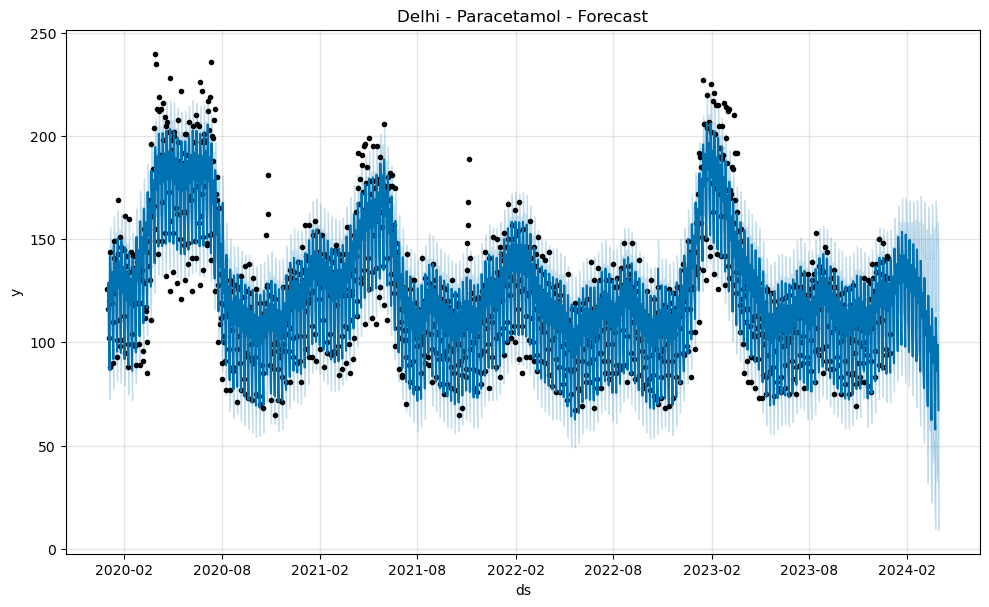

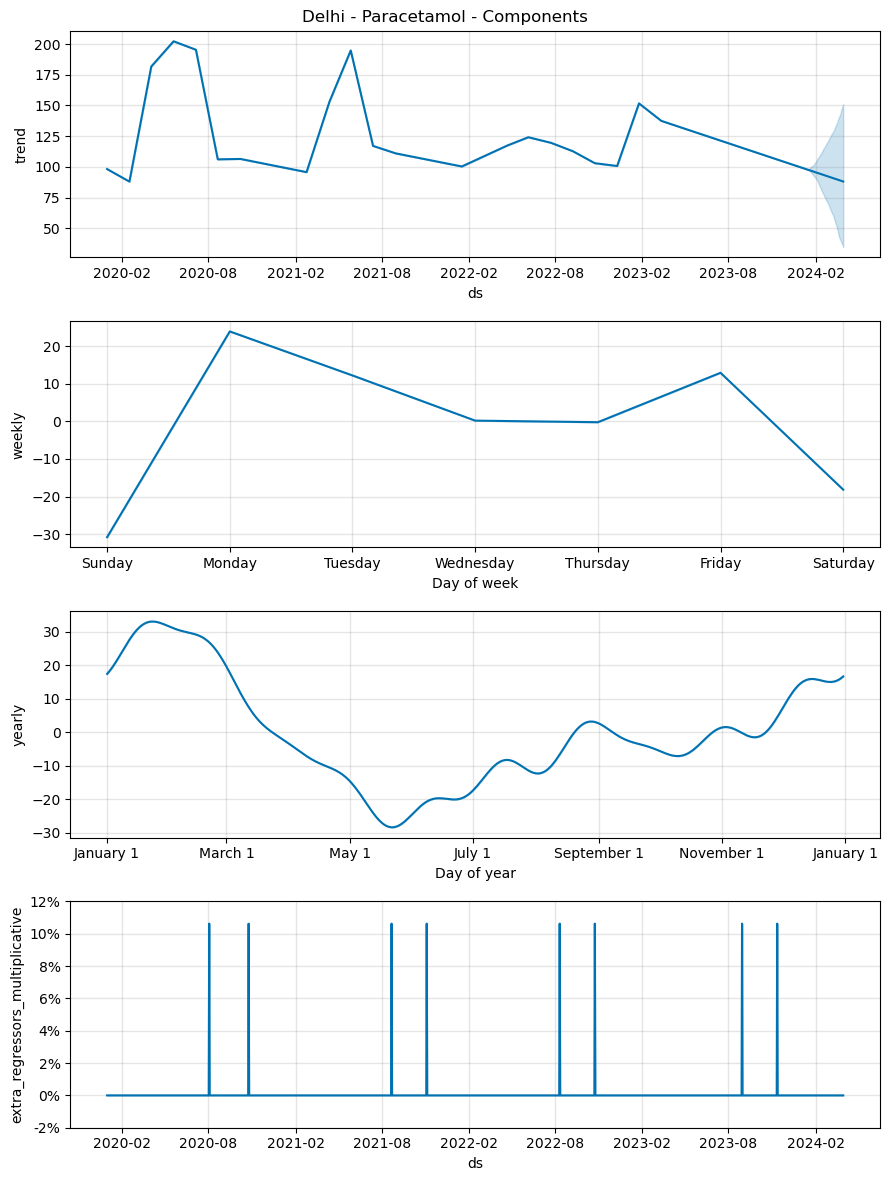

05:30:58 - cmdstanpy - INFO - Chain [1] start processing
05:30:58 - cmdstanpy - INFO - Chain [1] done processing



Training model for paracetamol in kolkata

Tuning hyperparameters...


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:30:58 - cmdstanpy - INFO - Chain [1] start processing
05:30:58 - cmdstanpy - INFO - Chain [1] done processing
05:30:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:30:58 - cmdstanpy - INFO - Chain [1] start processing
05:30:58 - cmdstanpy - INFO - Chain [1] done processing
05:30:59 - cmdstanpy - INFO - Chain [1] start processing
05:30:59 - cmdstanpy - INFO - Chain [1] done processing
05:30:59 - cmdstanpy - INFO - Chain [1] start processing
05:30:59 - cmdstanpy - INFO - Chain [1] done processing
05:30:59 - cmdstanpy - INFO - Chain [1] start processing
05:30:59 - cmdstanpy - INFO - Chain [1] done processing
05:30:59 - cmdstanpy - INFO - Chain [1] start processing
05:30:59 - cmdstanpy - INFO - Chain [1] done processing
05:30:59 - cmdstanpy - INFO - Chain [1] start processing
05:30:59 - cmdstanpy - INFO - Chain [1] done processing
05:30:59 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 44.16
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:01 - cmdstanpy - INFO - Chain [1] start processing
05:31:01 - cmdstanpy - INFO - Chain [1] done processing
05:31:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:31:01 - cmdstanpy - INFO - Chain [1] start processing
05:31:01 - cmdstanpy - INFO - Chain [1] done processing
05:31:01 - cmdstanpy - INFO - Chain [1] start processing
05:31:01 - cmdstanpy - INFO - Chain [1] done processing
05:31:01 - cmdstanpy - INFO - Chain [1] start processing
05:31:01 - cmdstanpy - INFO - Chain [1] done processing
05:31:01 - cmdstanpy - INFO - Chain [1] start processing
05:31:01 - cmdstanpy - INFO - Chain [1] done processing
05:31:02 - cmdstanpy - INFO - Chain [1] start processing
05:31:02 - cmdstanpy - INFO - Chain [1] done processing
05:31:02 - cmdstanpy - INFO - Chain [1] start processing
05:31:02 - cmdstanpy - INFO - Chain [1] done processing
05:31:02 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 34.71
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:03 - cmdstanpy - INFO - Chain [1] start processing
05:31:03 - cmdstanpy - INFO - Chain [1] done processing
05:31:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:31:03 - cmdstanpy - INFO - Chain [1] start processing
05:31:04 - cmdstanpy - INFO - Chain [1] done processing
05:31:04 - cmdstanpy - INFO - Chain [1] start processing
05:31:04 - cmdstanpy - INFO - Chain [1] done processing
05:31:04 - cmdstanpy - INFO - Chain [1] start processing
05:31:04 - cmdstanpy - INFO - Chain [1] done processing
05:31:04 - cmdstanpy - INFO - Chain [1] start processing
05:31:04 - cmdstanpy - INFO - Chain [1] done processing
05:31:04 - cmdstanpy - INFO - Chain [1] start processing
05:31:04 - cmdstanpy - INFO - Chain [1] done processing
05:31:04 - cmdstanpy - INFO - Chain [1] start processing
05:31:04 - cmdstanpy - INFO - Chain [1] done processing
05:31:04 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 36.33
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:06 - cmdstanpy - INFO - Chain [1] start processing
05:31:06 - cmdstanpy - INFO - Chain [1] done processing
05:31:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:31:06 - cmdstanpy - INFO - Chain [1] start processing
05:31:06 - cmdstanpy - INFO - Chain [1] done processing
05:31:06 - cmdstanpy - INFO - Chain [1] start processing
05:31:06 - cmdstanpy - INFO - Chain [1] done processing
05:31:06 - cmdstanpy - INFO - Chain [1] start processing
05:31:06 - cmdstanpy - INFO - Chain [1] done processing
05:31:06 - cmdstanpy - INFO - Chain [1] start processing
05:31:06 - cmdstanpy - INFO - Chain [1] done processing
05:31:07 - cmdstanpy - INFO - Chain [1] start processing
05:31:07 - cmdstanpy - INFO - Chain [1] done processing
05:31:07 - cmdstanpy - INFO - Chain [1] start processing
05:31:07 - cmdstanpy - INFO - Chain [1] done processing
05:31:07 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 38.75
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:08 - cmdstanpy - INFO - Chain [1] start processing
05:31:08 - cmdstanpy - INFO - Chain [1] done processing
05:31:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:31:08 - cmdstanpy - INFO - Chain [1] start processing
05:31:08 - cmdstanpy - INFO - Chain [1] done processing
05:31:09 - cmdstanpy - INFO - Chain [1] start processing
05:31:09 - cmdstanpy - INFO - Chain [1] done processing
05:31:09 - cmdstanpy - INFO - Chain [1] start processing
05:31:09 - cmdstanpy - INFO - Chain [1] done processing
05:31:09 - cmdstanpy - INFO - Chain [1] start processing
05:31:09 - cmdstanpy - INFO - Chain [1] done processing
05:31:09 - cmdstanpy - INFO - Chain [1] start processing
05:31:09 - cmdstanpy - INFO - Chain [1] done processing
05:31:09 - cmdstanpy - INFO - Chain [1] start processing
05:31:09 - cmdstanpy - INFO - Chain [1] done processing
05:31:09 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.15
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:11 - cmdstanpy - INFO - Chain [1] start processing
05:31:11 - cmdstanpy - INFO - Chain [1] done processing
05:31:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:31:11 - cmdstanpy - INFO - Chain [1] start processing
05:31:11 - cmdstanpy - INFO - Chain [1] done processing
05:31:11 - cmdstanpy - INFO - Chain [1] start processing
05:31:11 - cmdstanpy - INFO - Chain [1] done processing
05:31:11 - cmdstanpy - INFO - Chain [1] start processing
05:31:11 - cmdstanpy - INFO - Chain [1] done processing
05:31:11 - cmdstanpy - INFO - Chain [1] start processing
05:31:11 - cmdstanpy - INFO - Chain [1] done processing
05:31:12 - cmdstanpy - INFO - Chain [1] start processing
05:31:12 - cmdstanpy - INFO - Chain [1] done processing
05:31:12 - cmdstanpy - INFO - Chain [1] start processing
05:31:12 - cmdstanpy - INFO - Chain [1] done processing
05:31:12 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.92
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:13 - cmdstanpy - INFO - Chain [1] start processing
05:31:13 - cmdstanpy - INFO - Chain [1] done processing
05:31:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:31:13 - cmdstanpy - INFO - Chain [1] start processing
05:31:14 - cmdstanpy - INFO - Chain [1] done processing
05:31:14 - cmdstanpy - INFO - Chain [1] start processing
05:31:14 - cmdstanpy - INFO - Chain [1] done processing
05:31:14 - cmdstanpy - INFO - Chain [1] start processing
05:31:14 - cmdstanpy - INFO - Chain [1] done processing
05:31:14 - cmdstanpy - INFO - Chain [1] start processing
05:31:14 - cmdstanpy - INFO - Chain [1] done processing
05:31:14 - cmdstanpy - INFO - Chain [1] start processing
05:31:14 - cmdstanpy - INFO - Chain [1] done processing
05:31:15 - cmdstanpy - INFO - Chain [1] start processing
05:31:15 - cmdstanpy - INFO - Chain [1] done processing
05:31:15 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 36.82
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:16 - cmdstanpy - INFO - Chain [1] start processing
05:31:16 - cmdstanpy - INFO - Chain [1] done processing
05:31:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:31:16 - cmdstanpy - INFO - Chain [1] start processing
05:31:17 - cmdstanpy - INFO - Chain [1] done processing
05:31:17 - cmdstanpy - INFO - Chain [1] start processing
05:31:17 - cmdstanpy - INFO - Chain [1] done processing
05:31:17 - cmdstanpy - INFO - Chain [1] start processing
05:31:17 - cmdstanpy - INFO - Chain [1] done processing
05:31:17 - cmdstanpy - INFO - Chain [1] start processing
05:31:17 - cmdstanpy - INFO - Chain [1] done processing
05:31:17 - cmdstanpy - INFO - Chain [1] start processing
05:31:17 - cmdstanpy - INFO - Chain [1] done processing
05:31:18 - cmdstanpy - INFO - Chain [1] start processing
05:31:18 - cmdstanpy - INFO - Chain [1] done processing
05:31:18 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.07
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:19 - cmdstanpy - INFO - Chain [1] start processing
05:31:19 - cmdstanpy - INFO - Chain [1] done processing
05:31:19 - cmdstanpy - INFO - Chain [1] start processing
05:31:19 - cmdstanpy - INFO - Chain [1] done processing
05:31:19 - cmdstanpy - INFO - Chain [1] start processing
05:31:19 - cmdstanpy - INFO - Chain [1] done processing
05:31:20 - cmdstanpy - INFO - Chain [1] start processing
05:31:20 - cmdstanpy - INFO - Chain [1] done processing
05:31:20 - cmdstanpy - INFO - Chain [1] start processing
05:31:20 - cmdstanpy - INFO - Chain [1] done processing
05:31:20 - cmdstanpy - INFO - Chain [1] start processing
05:31:20 - cmdstanpy - INFO - Chain [1] done processing
05:31:20 - cmdstanpy - INFO - Chain [1] start processing
05:31:20 - cmdstanpy - INFO - Chain [1] done processing
05:31:20 - cmdstanpy - INFO - Chain [1] start processing
05:31:20 - cmdstanpy - INFO - Chain [1] done processing
05:31:21 - cmdstanpy - INFO - Chain [1] start processing
05:31:21 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.94
---


05:31:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:22 - cmdstanpy - INFO - Chain [1] start processing
05:31:22 - cmdstanpy - INFO - Chain [1] done processing
05:31:22 - cmdstanpy - INFO - Chain [1] start processing
05:31:22 - cmdstanpy - INFO - Chain [1] done processing
05:31:22 - cmdstanpy - INFO - Chain [1] start processing
05:31:22 - cmdstanpy - INFO - Chain [1] done processing
05:31:22 - cmdstanpy - INFO - Chain [1] start processing
05:31:22 - cmdstanpy - INFO - Chain [1] done processing
05:31:22 - cmdstanpy - INFO - Chain [1] start processing
05:31:22 - cmdstanpy - INFO - Chain [1] done processing
05:31:23 - cmdstanpy - INFO - Chain [1] start processing
05:31:23 - cmdstanpy - INFO - Chain [1] done processing
05:31:23 - cmdstanpy - INFO - Chain [1] start processing
05:31:23 - cmdstanpy - INFO - Chain [1] done processing
05:31:23 - cmdstanpy - INFO - Chain [1] start processing
05:31:23 - cmdstanpy - INFO - Chain [1] done processing
05:31:23 - cmdstanpy - INFO - Chain [1] start processing
05:31:23 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.77
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:24 - cmdstanpy - INFO - Chain [1] start processing
05:31:24 - cmdstanpy - INFO - Chain [1] done processing
05:31:24 - cmdstanpy - INFO - Chain [1] start processing
05:31:24 - cmdstanpy - INFO - Chain [1] done processing
05:31:24 - cmdstanpy - INFO - Chain [1] start processing
05:31:24 - cmdstanpy - INFO - Chain [1] done processing
05:31:24 - cmdstanpy - INFO - Chain [1] start processing
05:31:24 - cmdstanpy - INFO - Chain [1] done processing
05:31:25 - cmdstanpy - INFO - Chain [1] start processing
05:31:25 - cmdstanpy - INFO - Chain [1] done processing
05:31:25 - cmdstanpy - INFO - Chain [1] start processing
05:31:25 - cmdstanpy - INFO - Chain [1] done processing
05:31:25 - cmdstanpy - INFO - Chain [1] start processing
05:31:25 - cmdstanpy - INFO - Chain [1] done processing
05:31:25 - cmdstanpy - INFO - Chain [1] start processing
05:31:25 - cmdstanpy - INFO - Chain [1] done processing
05:31:25 - cmdstanpy - INFO - Chain [1] start processing
05:31:25 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.48
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:26 - cmdstanpy - INFO - Chain [1] start processing
05:31:26 - cmdstanpy - INFO - Chain [1] done processing
05:31:26 - cmdstanpy - INFO - Chain [1] start processing
05:31:26 - cmdstanpy - INFO - Chain [1] done processing
05:31:26 - cmdstanpy - INFO - Chain [1] start processing
05:31:26 - cmdstanpy - INFO - Chain [1] done processing
05:31:27 - cmdstanpy - INFO - Chain [1] start processing
05:31:27 - cmdstanpy - INFO - Chain [1] done processing
05:31:27 - cmdstanpy - INFO - Chain [1] start processing
05:31:27 - cmdstanpy - INFO - Chain [1] done processing
05:31:27 - cmdstanpy - INFO - Chain [1] start processing
05:31:27 - cmdstanpy - INFO - Chain [1] done processing
05:31:27 - cmdstanpy - INFO - Chain [1] start processing
05:31:27 - cmdstanpy - INFO - Chain [1] done processing
05:31:27 - cmdstanpy - INFO - Chain [1] start processing
05:31:27 - cmdstanpy - INFO - Chain [1] done processing
05:31:27 - cmdstanpy - INFO - Chain [1] start processing
05:31:27 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 43.94
---


05:31:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:28 - cmdstanpy - INFO - Chain [1] start processing
05:31:28 - cmdstanpy - INFO - Chain [1] done processing
05:31:29 - cmdstanpy - INFO - Chain [1] start processing
05:31:29 - cmdstanpy - INFO - Chain [1] done processing
05:31:29 - cmdstanpy - INFO - Chain [1] start processing
05:31:29 - cmdstanpy - INFO - Chain [1] done processing
05:31:29 - cmdstanpy - INFO - Chain [1] start processing
05:31:29 - cmdstanpy - INFO - Chain [1] done processing
05:31:29 - cmdstanpy - INFO - Chain [1] start processing
05:31:29 - cmdstanpy - INFO - Chain [1] done processing
05:31:29 - cmdstanpy - INFO - Chain [1] start processing
05:31:29 - cmdstanpy - INFO - Chain [1] done processing
05:31:29 - cmdstanpy - INFO - Chain [1] start processing
05:31:29 - cmdstanpy - INFO - Chain [1] done processing
05:31:29 - cmdstanpy - INFO - Chain [1] start processing
05:31:30 - cmdstanpy - INFO - Chain [1] done processing
05:31:30 - cmdstanpy - INFO - Chain [1] start processing
05:31:30 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 42.65
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:31 - cmdstanpy - INFO - Chain [1] start processing
05:31:31 - cmdstanpy - INFO - Chain [1] done processing
05:31:31 - cmdstanpy - INFO - Chain [1] start processing
05:31:31 - cmdstanpy - INFO - Chain [1] done processing
05:31:31 - cmdstanpy - INFO - Chain [1] start processing
05:31:31 - cmdstanpy - INFO - Chain [1] done processing
05:31:31 - cmdstanpy - INFO - Chain [1] start processing
05:31:31 - cmdstanpy - INFO - Chain [1] done processing
05:31:31 - cmdstanpy - INFO - Chain [1] start processing
05:31:31 - cmdstanpy - INFO - Chain [1] done processing
05:31:31 - cmdstanpy - INFO - Chain [1] start processing
05:31:31 - cmdstanpy - INFO - Chain [1] done processing
05:31:32 - cmdstanpy - INFO - Chain [1] start processing
05:31:32 - cmdstanpy - INFO - Chain [1] done processing
05:31:32 - cmdstanpy - INFO - Chain [1] start processing
05:31:32 - cmdstanpy - INFO - Chain [1] done processing
05:31:32 - cmdstanpy - INFO - Chain [1] start processing
05:31:32 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 43.66
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:33 - cmdstanpy - INFO - Chain [1] start processing
05:31:33 - cmdstanpy - INFO - Chain [1] done processing
05:31:33 - cmdstanpy - INFO - Chain [1] start processing
05:31:33 - cmdstanpy - INFO - Chain [1] done processing
05:31:33 - cmdstanpy - INFO - Chain [1] start processing
05:31:33 - cmdstanpy - INFO - Chain [1] done processing
05:31:33 - cmdstanpy - INFO - Chain [1] start processing
05:31:33 - cmdstanpy - INFO - Chain [1] done processing
05:31:33 - cmdstanpy - INFO - Chain [1] start processing
05:31:34 - cmdstanpy - INFO - Chain [1] done processing
05:31:34 - cmdstanpy - INFO - Chain [1] start processing
05:31:34 - cmdstanpy - INFO - Chain [1] done processing
05:31:34 - cmdstanpy - INFO - Chain [1] start processing
05:31:34 - cmdstanpy - INFO - Chain [1] done processing
05:31:34 - cmdstanpy - INFO - Chain [1] start processing
05:31:34 - cmdstanpy - INFO - Chain [1] done processing
05:31:34 - cmdstanpy - INFO - Chain [1] start processing
05:31:34 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.21
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:35 - cmdstanpy - INFO - Chain [1] start processing
05:31:35 - cmdstanpy - INFO - Chain [1] done processing
05:31:35 - cmdstanpy - INFO - Chain [1] start processing
05:31:35 - cmdstanpy - INFO - Chain [1] done processing
05:31:35 - cmdstanpy - INFO - Chain [1] start processing
05:31:36 - cmdstanpy - INFO - Chain [1] done processing
05:31:36 - cmdstanpy - INFO - Chain [1] start processing
05:31:36 - cmdstanpy - INFO - Chain [1] done processing
05:31:36 - cmdstanpy - INFO - Chain [1] start processing
05:31:36 - cmdstanpy - INFO - Chain [1] done processing
05:31:36 - cmdstanpy - INFO - Chain [1] start processing
05:31:36 - cmdstanpy - INFO - Chain [1] done processing
05:31:36 - cmdstanpy - INFO - Chain [1] start processing
05:31:36 - cmdstanpy - INFO - Chain [1] done processing
05:31:36 - cmdstanpy - INFO - Chain [1] start processing
05:31:36 - cmdstanpy - INFO - Chain [1] done processing
05:31:36 - cmdstanpy - INFO - Chain [1] start processing
05:31:37 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 43.88
---


05:31:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:37 - cmdstanpy - INFO - Chain [1] start processing
05:31:38 - cmdstanpy - INFO - Chain [1] done processing
05:31:38 - cmdstanpy - INFO - Chain [1] start processing
05:31:38 - cmdstanpy - INFO - Chain [1] done processing
05:31:38 - cmdstanpy - INFO - Chain [1] start processing
05:31:38 - cmdstanpy - INFO - Chain [1] done processing
05:31:38 - cmdstanpy - INFO - Chain [1] start processing
05:31:38 - cmdstanpy - INFO - Chain [1] done processing
05:31:38 - cmdstanpy - INFO - Chain [1] start processing
05:31:38 - cmdstanpy - INFO - Chain [1] done processing
05:31:38 - cmdstanpy - INFO - Chain [1] start processing
05:31:39 - cmdstanpy - INFO - Chain [1] done processing
05:31:39 - cmdstanpy - INFO - Chain [1] start processing
05:31:39 - cmdstanpy - INFO - Chain [1] done processing
05:31:39 - cmdstanpy - INFO - Chain [1] start processing
05:31:39 - cmdstanpy - INFO - Chain [1] done processing
05:31:39 - cmdstanpy - INFO - Chain [1] start processing
05:31:39 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 52.71
---


05:31:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:41 - cmdstanpy - INFO - Chain [1] start processing
05:31:41 - cmdstanpy - INFO - Chain [1] done processing
05:31:41 - cmdstanpy - INFO - Chain [1] start processing
05:31:41 - cmdstanpy - INFO - Chain [1] done processing
05:31:41 - cmdstanpy - INFO - Chain [1] start processing
05:31:41 - cmdstanpy - INFO - Chain [1] done processing
05:31:41 - cmdstanpy - INFO - Chain [1] start processing
05:31:41 - cmdstanpy - INFO - Chain [1] done processing
05:31:42 - cmdstanpy - INFO - Chain [1] start processing
05:31:42 - cmdstanpy - INFO - Chain [1] done processing
05:31:42 - cmdstanpy - INFO - Chain [1] start processing
05:31:42 - cmdstanpy - INFO - Chain [1] done processing
05:31:42 - cmdstanpy - INFO - Chain [1] start processing
05:31:42 - cmdstanpy - INFO - Chain [1] done processing
05:31:42 - cmdstanpy - INFO - Chain [1] start processing
05:31:42 - cmdstanpy - INFO - Chain [1] done processing
05:31:42 - cmdstanpy - INFO - Chain [1] start processing
05:31:43 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.56
---


05:31:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:44 - cmdstanpy - INFO - Chain [1] start processing
05:31:44 - cmdstanpy - INFO - Chain [1] done processing
05:31:44 - cmdstanpy - INFO - Chain [1] start processing
05:31:44 - cmdstanpy - INFO - Chain [1] done processing
05:31:44 - cmdstanpy - INFO - Chain [1] start processing
05:31:44 - cmdstanpy - INFO - Chain [1] done processing
05:31:44 - cmdstanpy - INFO - Chain [1] start processing
05:31:44 - cmdstanpy - INFO - Chain [1] done processing
05:31:44 - cmdstanpy - INFO - Chain [1] start processing
05:31:44 - cmdstanpy - INFO - Chain [1] done processing
05:31:44 - cmdstanpy - INFO - Chain [1] start processing
05:31:45 - cmdstanpy - INFO - Chain [1] done processing
05:31:45 - cmdstanpy - INFO - Chain [1] start processing
05:31:45 - cmdstanpy - INFO - Chain [1] done processing
05:31:45 - cmdstanpy - INFO - Chain [1] start processing
05:31:45 - cmdstanpy - INFO - Chain [1] done processing
05:31:45 - cmdstanpy - INFO - Chain [1] start processing
05:31:45 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 49.51
---


05:31:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:47 - cmdstanpy - INFO - Chain [1] start processing
05:31:47 - cmdstanpy - INFO - Chain [1] done processing
05:31:47 - cmdstanpy - INFO - Chain [1] start processing
05:31:47 - cmdstanpy - INFO - Chain [1] done processing
05:31:47 - cmdstanpy - INFO - Chain [1] start processing
05:31:47 - cmdstanpy - INFO - Chain [1] done processing
05:31:47 - cmdstanpy - INFO - Chain [1] start processing
05:31:47 - cmdstanpy - INFO - Chain [1] done processing
05:31:47 - cmdstanpy - INFO - Chain [1] start processing
05:31:47 - cmdstanpy - INFO - Chain [1] done processing
05:31:47 - cmdstanpy - INFO - Chain [1] start processing
05:31:48 - cmdstanpy - INFO - Chain [1] done processing
05:31:48 - cmdstanpy - INFO - Chain [1] start processing
05:31:48 - cmdstanpy - INFO - Chain [1] done processing
05:31:48 - cmdstanpy - INFO - Chain [1] start processing
05:31:48 - cmdstanpy - INFO - Chain [1] done processing
05:31:48 - cmdstanpy - INFO - Chain [1] start processing
05:31:48 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.71
---


05:31:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:49 - cmdstanpy - INFO - Chain [1] start processing
05:31:49 - cmdstanpy - INFO - Chain [1] done processing
05:31:49 - cmdstanpy - INFO - Chain [1] start processing
05:31:50 - cmdstanpy - INFO - Chain [1] done processing
05:31:50 - cmdstanpy - INFO - Chain [1] start processing
05:31:50 - cmdstanpy - INFO - Chain [1] done processing
05:31:50 - cmdstanpy - INFO - Chain [1] start processing
05:31:50 - cmdstanpy - INFO - Chain [1] done processing
05:31:50 - cmdstanpy - INFO - Chain [1] start processing
05:31:50 - cmdstanpy - INFO - Chain [1] done processing
05:31:50 - cmdstanpy - INFO - Chain [1] start processing
05:31:50 - cmdstanpy - INFO - Chain [1] done processing
05:31:50 - cmdstanpy - INFO - Chain [1] start processing
05:31:50 - cmdstanpy - INFO - Chain [1] done processing
05:31:51 - cmdstanpy - INFO - Chain [1] start processing
05:31:51 - cmdstanpy - INFO - Chain [1] done processing
05:31:51 - cmdstanpy - INFO - Chain [1] start processing
05:31:51 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.33
---


05:31:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:52 - cmdstanpy - INFO - Chain [1] start processing
05:31:53 - cmdstanpy - INFO - Chain [1] done processing
05:31:53 - cmdstanpy - INFO - Chain [1] start processing
05:31:53 - cmdstanpy - INFO - Chain [1] done processing
05:31:53 - cmdstanpy - INFO - Chain [1] start processing
05:31:53 - cmdstanpy - INFO - Chain [1] done processing
05:31:53 - cmdstanpy - INFO - Chain [1] start processing
05:31:53 - cmdstanpy - INFO - Chain [1] done processing
05:31:53 - cmdstanpy - INFO - Chain [1] start processing
05:31:53 - cmdstanpy - INFO - Chain [1] done processing
05:31:53 - cmdstanpy - INFO - Chain [1] start processing
05:31:53 - cmdstanpy - INFO - Chain [1] done processing
05:31:54 - cmdstanpy - INFO - Chain [1] start processing
05:31:54 - cmdstanpy - INFO - Chain [1] done processing
05:31:54 - cmdstanpy - INFO - Chain [1] start processing
05:31:54 - cmdstanpy - INFO - Chain [1] done processing
05:31:54 - cmdstanpy - INFO - Chain [1] start processing
05:31:54 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 52.37
---


05:31:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:55 - cmdstanpy - INFO - Chain [1] start processing
05:31:55 - cmdstanpy - INFO - Chain [1] done processing
05:31:56 - cmdstanpy - INFO - Chain [1] start processing
05:31:56 - cmdstanpy - INFO - Chain [1] done processing
05:31:56 - cmdstanpy - INFO - Chain [1] start processing
05:31:56 - cmdstanpy - INFO - Chain [1] done processing
05:31:56 - cmdstanpy - INFO - Chain [1] start processing
05:31:56 - cmdstanpy - INFO - Chain [1] done processing
05:31:56 - cmdstanpy - INFO - Chain [1] start processing
05:31:56 - cmdstanpy - INFO - Chain [1] done processing
05:31:56 - cmdstanpy - INFO - Chain [1] start processing
05:31:56 - cmdstanpy - INFO - Chain [1] done processing
05:31:57 - cmdstanpy - INFO - Chain [1] start processing
05:31:57 - cmdstanpy - INFO - Chain [1] done processing
05:31:57 - cmdstanpy - INFO - Chain [1] start processing
05:31:57 - cmdstanpy - INFO - Chain [1] done processing
05:31:57 - cmdstanpy - INFO - Chain [1] start processing
05:31:57 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 50.65
---


05:31:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:31:59 - cmdstanpy - INFO - Chain [1] start processing
05:31:59 - cmdstanpy - INFO - Chain [1] done processing
05:31:59 - cmdstanpy - INFO - Chain [1] start processing
05:31:59 - cmdstanpy - INFO - Chain [1] done processing
05:31:59 - cmdstanpy - INFO - Chain [1] start processing
05:31:59 - cmdstanpy - INFO - Chain [1] done processing
05:31:59 - cmdstanpy - INFO - Chain [1] start processing
05:31:59 - cmdstanpy - INFO - Chain [1] done processing
05:31:59 - cmdstanpy - INFO - Chain [1] start processing
05:32:00 - cmdstanpy - INFO - Chain [1] done processing
05:32:00 - cmdstanpy - INFO - Chain [1] start processing
05:32:00 - cmdstanpy - INFO - Chain [1] done processing
05:32:00 - cmdstanpy - INFO - Chain [1] start processing
05:32:00 - cmdstanpy - INFO - Chain [1] done processing
05:32:00 - cmdstanpy - INFO - Chain [1] start processing
05:32:00 - cmdstanpy - INFO - Chain [1] done processing
05:32:00 - cmdstanpy - INFO - Chain [1] start processing
05:32:00 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.51
---


05:32:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:32:02 - cmdstanpy - INFO - Chain [1] start processing
05:32:02 - cmdstanpy - INFO - Chain [1] done processing
05:32:02 - cmdstanpy - INFO - Chain [1] start processing
05:32:02 - cmdstanpy - INFO - Chain [1] done processing
05:32:02 - cmdstanpy - INFO - Chain [1] start processing
05:32:03 - cmdstanpy - INFO - Chain [1] done processing
05:32:03 - cmdstanpy - INFO - Chain [1] start processing
05:32:03 - cmdstanpy - INFO - Chain [1] done processing
05:32:03 - cmdstanpy - INFO - Chain [1] start processing
05:32:03 - cmdstanpy - INFO - Chain [1] done processing
05:32:03 - cmdstanpy - INFO - Chain [1] start processing
05:32:03 - cmdstanpy - INFO - Chain [1] done processing
05:32:04 - cmdstanpy - INFO - Chain [1] start processing
05:32:04 - cmdstanpy - INFO - Chain [1] done processing
05:32:04 - cmdstanpy - INFO - Chain [1] start processing
05:32:04 - cmdstanpy - INFO - Chain [1] done processing
05:32:04 - cmdstanpy - INFO - Chain [1] start processing
05:32:04 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 57.57
---


05:32:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:32:06 - cmdstanpy - INFO - Chain [1] start processing
05:32:06 - cmdstanpy - INFO - Chain [1] done processing
05:32:06 - cmdstanpy - INFO - Chain [1] start processing
05:32:06 - cmdstanpy - INFO - Chain [1] done processing
05:32:06 - cmdstanpy - INFO - Chain [1] start processing
05:32:06 - cmdstanpy - INFO - Chain [1] done processing
05:32:06 - cmdstanpy - INFO - Chain [1] start processing
05:32:07 - cmdstanpy - INFO - Chain [1] done processing
05:32:07 - cmdstanpy - INFO - Chain [1] start processing
05:32:07 - cmdstanpy - INFO - Chain [1] done processing
05:32:07 - cmdstanpy - INFO - Chain [1] start processing
05:32:07 - cmdstanpy - INFO - Chain [1] done processing
05:32:07 - cmdstanpy - INFO - Chain [1] start processing
05:32:07 - cmdstanpy - INFO - Chain [1] done processing
05:32:08 - cmdstanpy - INFO - Chain [1] start processing
05:32:08 - cmdstanpy - INFO - Chain [1] done processing
05:32:08 - cmdstanpy - INFO - Chain [1] start processing
05:32:08 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 50.49
---


05:32:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:32:10 - cmdstanpy - INFO - Chain [1] start processing
05:32:10 - cmdstanpy - INFO - Chain [1] done processing
05:32:10 - cmdstanpy - INFO - Chain [1] start processing
05:32:10 - cmdstanpy - INFO - Chain [1] done processing
05:32:10 - cmdstanpy - INFO - Chain [1] start processing
05:32:10 - cmdstanpy - INFO - Chain [1] done processing
05:32:10 - cmdstanpy - INFO - Chain [1] start processing
05:32:10 - cmdstanpy - INFO - Chain [1] done processing
05:32:11 - cmdstanpy - INFO - Chain [1] start processing
05:32:11 - cmdstanpy - INFO - Chain [1] done processing
05:32:11 - cmdstanpy - INFO - Chain [1] start processing
05:32:11 - cmdstanpy - INFO - Chain [1] done processing
05:32:11 - cmdstanpy - INFO - Chain [1] start processing
05:32:11 - cmdstanpy - INFO - Chain [1] done processing
05:32:11 - cmdstanpy - INFO - Chain [1] start processing
05:32:12 - cmdstanpy - INFO - Chain [1] done processing
05:32:12 - cmdstanpy - INFO - Chain [1] start processing
05:32:12 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 48.18
---


05:32:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:32:13 - cmdstanpy - INFO - Chain [1] start processing
05:32:14 - cmdstanpy - INFO - Chain [1] done processing
05:32:14 - cmdstanpy - INFO - Chain [1] start processing
05:32:14 - cmdstanpy - INFO - Chain [1] done processing
05:32:14 - cmdstanpy - INFO - Chain [1] start processing
05:32:14 - cmdstanpy - INFO - Chain [1] done processing
05:32:14 - cmdstanpy - INFO - Chain [1] start processing
05:32:14 - cmdstanpy - INFO - Chain [1] done processing
05:32:14 - cmdstanpy - INFO - Chain [1] start processing
05:32:14 - cmdstanpy - INFO - Chain [1] done processing
05:32:14 - cmdstanpy - INFO - Chain [1] start processing
05:32:15 - cmdstanpy - INFO - Chain [1] done processing
05:32:15 - cmdstanpy - INFO - Chain [1] start processing
05:32:15 - cmdstanpy - INFO - Chain [1] done processing
05:32:15 - cmdstanpy - INFO - Chain [1] start processing
05:32:15 - cmdstanpy - INFO - Chain [1] done processing
05:32:15 - cmdstanpy - INFO - Chain [1] start processing
05:32:15 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.53
---


05:32:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:32:17 - cmdstanpy - INFO - Chain [1] start processing
05:32:17 - cmdstanpy - INFO - Chain [1] done processing
05:32:17 - cmdstanpy - INFO - Chain [1] start processing
05:32:17 - cmdstanpy - INFO - Chain [1] done processing
05:32:17 - cmdstanpy - INFO - Chain [1] start processing
05:32:17 - cmdstanpy - INFO - Chain [1] done processing
05:32:17 - cmdstanpy - INFO - Chain [1] start processing
05:32:18 - cmdstanpy - INFO - Chain [1] done processing
05:32:18 - cmdstanpy - INFO - Chain [1] start processing
05:32:18 - cmdstanpy - INFO - Chain [1] done processing
05:32:18 - cmdstanpy - INFO - Chain [1] start processing
05:32:18 - cmdstanpy - INFO - Chain [1] done processing
05:32:18 - cmdstanpy - INFO - Chain [1] start processing
05:32:18 - cmdstanpy - INFO - Chain [1] done processing
05:32:18 - cmdstanpy - INFO - Chain [1] start processing
05:32:19 - cmdstanpy - INFO - Chain [1] done processing
05:32:19 - cmdstanpy - INFO - Chain [1] start processing
05:32:19 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 47.88
---


05:32:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:32:21 - cmdstanpy - INFO - Chain [1] start processing
05:32:21 - cmdstanpy - INFO - Chain [1] done processing
05:32:21 - cmdstanpy - INFO - Chain [1] start processing
05:32:21 - cmdstanpy - INFO - Chain [1] done processing
05:32:21 - cmdstanpy - INFO - Chain [1] start processing
05:32:21 - cmdstanpy - INFO - Chain [1] done processing
05:32:21 - cmdstanpy - INFO - Chain [1] start processing
05:32:21 - cmdstanpy - INFO - Chain [1] done processing
05:32:21 - cmdstanpy - INFO - Chain [1] start processing
05:32:21 - cmdstanpy - INFO - Chain [1] done processing
05:32:22 - cmdstanpy - INFO - Chain [1] start processing
05:32:22 - cmdstanpy - INFO - Chain [1] done processing
05:32:22 - cmdstanpy - INFO - Chain [1] start processing
05:32:22 - cmdstanpy - INFO - Chain [1] done processing
05:32:22 - cmdstanpy - INFO - Chain [1] start processing
05:32:22 - cmdstanpy - INFO - Chain [1] done processing
05:32:22 - cmdstanpy - INFO - Chain [1] start processing
05:32:22 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 52.14
---


05:32:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:32:24 - cmdstanpy - INFO - Chain [1] start processing
05:32:24 - cmdstanpy - INFO - Chain [1] done processing
05:32:24 - cmdstanpy - INFO - Chain [1] start processing
05:32:24 - cmdstanpy - INFO - Chain [1] done processing
05:32:25 - cmdstanpy - INFO - Chain [1] start processing
05:32:25 - cmdstanpy - INFO - Chain [1] done processing
05:32:25 - cmdstanpy - INFO - Chain [1] start processing
05:32:25 - cmdstanpy - INFO - Chain [1] done processing
05:32:25 - cmdstanpy - INFO - Chain [1] start processing
05:32:25 - cmdstanpy - INFO - Chain [1] done processing
05:32:25 - cmdstanpy - INFO - Chain [1] start processing
05:32:25 - cmdstanpy - INFO - Chain [1] done processing
05:32:25 - cmdstanpy - INFO - Chain [1] start processing
05:32:26 - cmdstanpy - INFO - Chain [1] done processing
05:32:26 - cmdstanpy - INFO - Chain [1] start processing
05:32:26 - cmdstanpy - INFO - Chain [1] done processing
05:32:26 - cmdstanpy - INFO - Chain [1] start processing
05:32:26 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 47.60
---


05:32:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:32:28 - cmdstanpy - INFO - Chain [1] start processing
05:32:28 - cmdstanpy - INFO - Chain [1] done processing
05:32:28 - cmdstanpy - INFO - Chain [1] start processing
05:32:28 - cmdstanpy - INFO - Chain [1] done processing
05:32:28 - cmdstanpy - INFO - Chain [1] start processing
05:32:28 - cmdstanpy - INFO - Chain [1] done processing
05:32:28 - cmdstanpy - INFO - Chain [1] start processing
05:32:28 - cmdstanpy - INFO - Chain [1] done processing
05:32:28 - cmdstanpy - INFO - Chain [1] start processing
05:32:29 - cmdstanpy - INFO - Chain [1] done processing
05:32:29 - cmdstanpy - INFO - Chain [1] start processing
05:32:29 - cmdstanpy - INFO - Chain [1] done processing
05:32:29 - cmdstanpy - INFO - Chain [1] start processing
05:32:29 - cmdstanpy - INFO - Chain [1] done processing
05:32:29 - cmdstanpy - INFO - Chain [1] start processing
05:32:29 - cmdstanpy - INFO - Chain [1] done processing
05:32:29 - cmdstanpy - INFO - Chain [1] start processing
05:32:30 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 52.04
---


05:32:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:32:31 - cmdstanpy - INFO - Chain [1] start processing
05:32:32 - cmdstanpy - INFO - Chain [1] done processing
05:32:32 - cmdstanpy - INFO - Chain [1] start processing
05:32:32 - cmdstanpy - INFO - Chain [1] done processing
05:32:32 - cmdstanpy - INFO - Chain [1] start processing
05:32:32 - cmdstanpy - INFO - Chain [1] done processing
05:32:32 - cmdstanpy - INFO - Chain [1] start processing
05:32:32 - cmdstanpy - INFO - Chain [1] done processing
05:32:32 - cmdstanpy - INFO - Chain [1] start processing
05:32:33 - cmdstanpy - INFO - Chain [1] done processing
05:32:33 - cmdstanpy - INFO - Chain [1] start processing
05:32:33 - cmdstanpy - INFO - Chain [1] done processing
05:32:33 - cmdstanpy - INFO - Chain [1] start processing
05:32:34 - cmdstanpy - INFO - Chain [1] done processing
05:32:34 - cmdstanpy - INFO - Chain [1] start processing
05:32:34 - cmdstanpy - INFO - Chain [1] done processing
05:32:34 - cmdstanpy - INFO - Chain [1] start processing
05:32:35 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 62.65
---


05:32:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:32:37 - cmdstanpy - INFO - Chain [1] start processing
05:32:37 - cmdstanpy - INFO - Chain [1] done processing
05:32:37 - cmdstanpy - INFO - Chain [1] start processing
05:32:37 - cmdstanpy - INFO - Chain [1] done processing
05:32:37 - cmdstanpy - INFO - Chain [1] start processing
05:32:37 - cmdstanpy - INFO - Chain [1] done processing
05:32:37 - cmdstanpy - INFO - Chain [1] start processing
05:32:38 - cmdstanpy - INFO - Chain [1] done processing
05:32:38 - cmdstanpy - INFO - Chain [1] start processing
05:32:38 - cmdstanpy - INFO - Chain [1] done processing
05:32:38 - cmdstanpy - INFO - Chain [1] start processing
05:32:38 - cmdstanpy - INFO - Chain [1] done processing
05:32:38 - cmdstanpy - INFO - Chain [1] start processing
05:32:39 - cmdstanpy - INFO - Chain [1] done processing
05:32:39 - cmdstanpy - INFO - Chain [1] start processing
05:32:39 - cmdstanpy - INFO - Chain [1] done processing
05:32:39 - cmdstanpy - INFO - Chain [1] start processing
05:32:40 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 52.11
---


05:32:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:32:42 - cmdstanpy - INFO - Chain [1] start processing
05:32:42 - cmdstanpy - INFO - Chain [1] done processing
05:32:42 - cmdstanpy - INFO - Chain [1] start processing
05:32:42 - cmdstanpy - INFO - Chain [1] done processing
05:32:42 - cmdstanpy - INFO - Chain [1] start processing
05:32:42 - cmdstanpy - INFO - Chain [1] done processing
05:32:42 - cmdstanpy - INFO - Chain [1] start processing
05:32:43 - cmdstanpy - INFO - Chain [1] done processing
05:32:43 - cmdstanpy - INFO - Chain [1] start processing
05:32:43 - cmdstanpy - INFO - Chain [1] done processing
05:32:43 - cmdstanpy - INFO - Chain [1] start processing
05:32:43 - cmdstanpy - INFO - Chain [1] done processing
05:32:43 - cmdstanpy - INFO - Chain [1] start processing
05:32:44 - cmdstanpy - INFO - Chain [1] done processing
05:32:44 - cmdstanpy - INFO - Chain [1] start processing
05:32:44 - cmdstanpy - INFO - Chain [1] done processing
05:32:44 - cmdstanpy - INFO - Chain [1] start processing
05:32:45 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 46.13
---


05:32:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:32:47 - cmdstanpy - INFO - Chain [1] start processing
05:32:47 - cmdstanpy - INFO - Chain [1] done processing
05:32:47 - cmdstanpy - INFO - Chain [1] start processing
05:32:47 - cmdstanpy - INFO - Chain [1] done processing
05:32:47 - cmdstanpy - INFO - Chain [1] start processing
05:32:47 - cmdstanpy - INFO - Chain [1] done processing
05:32:48 - cmdstanpy - INFO - Chain [1] start processing
05:32:48 - cmdstanpy - INFO - Chain [1] done processing
05:32:48 - cmdstanpy - INFO - Chain [1] start processing
05:32:48 - cmdstanpy - INFO - Chain [1] done processing
05:32:48 - cmdstanpy - INFO - Chain [1] start processing
05:32:48 - cmdstanpy - INFO - Chain [1] done processing
05:32:48 - cmdstanpy - INFO - Chain [1] start processing
05:32:49 - cmdstanpy - INFO - Chain [1] done processing
05:32:49 - cmdstanpy - INFO - Chain [1] start processing
05:32:49 - cmdstanpy - INFO - Chain [1] done processing
05:32:49 - cmdstanpy - INFO - Chain [1] start processing
05:32:50 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 49.98
---


05:32:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:32:52 - cmdstanpy - INFO - Chain [1] start processing
05:32:52 - cmdstanpy - INFO - Chain [1] done processing
05:32:53 - cmdstanpy - INFO - Chain [1] start processing
05:32:53 - cmdstanpy - INFO - Chain [1] done processing
05:32:53 - cmdstanpy - INFO - Chain [1] start processing
05:32:53 - cmdstanpy - INFO - Chain [1] done processing
05:32:53 - cmdstanpy - INFO - Chain [1] start processing
05:32:53 - cmdstanpy - INFO - Chain [1] done processing
05:32:53 - cmdstanpy - INFO - Chain [1] start processing
05:32:54 - cmdstanpy - INFO - Chain [1] done processing
05:32:54 - cmdstanpy - INFO - Chain [1] start processing
05:32:54 - cmdstanpy - INFO - Chain [1] done processing
05:32:54 - cmdstanpy - INFO - Chain [1] start processing
05:32:54 - cmdstanpy - INFO - Chain [1] done processing
05:32:55 - cmdstanpy - INFO - Chain [1] start processing
05:32:55 - cmdstanpy - INFO - Chain [1] done processing
05:32:55 - cmdstanpy - INFO - Chain [1] start processing
05:32:55 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 46.15
---


05:32:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:32:58 - cmdstanpy - INFO - Chain [1] start processing
05:32:58 - cmdstanpy - INFO - Chain [1] done processing
05:32:58 - cmdstanpy - INFO - Chain [1] start processing
05:32:58 - cmdstanpy - INFO - Chain [1] done processing
05:32:58 - cmdstanpy - INFO - Chain [1] start processing
05:32:58 - cmdstanpy - INFO - Chain [1] done processing
05:32:58 - cmdstanpy - INFO - Chain [1] start processing
05:32:58 - cmdstanpy - INFO - Chain [1] done processing
05:32:58 - cmdstanpy - INFO - Chain [1] start processing
05:32:59 - cmdstanpy - INFO - Chain [1] done processing
05:32:59 - cmdstanpy - INFO - Chain [1] start processing
05:32:59 - cmdstanpy - INFO - Chain [1] done processing
05:32:59 - cmdstanpy - INFO - Chain [1] start processing
05:32:59 - cmdstanpy - INFO - Chain [1] done processing
05:32:59 - cmdstanpy - INFO - Chain [1] start processing
05:33:00 - cmdstanpy - INFO - Chain [1] done processing
05:33:00 - cmdstanpy - INFO - Chain [1] start processing
05:33:00 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.84
---


05:33:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:33:03 - cmdstanpy - INFO - Chain [1] start processing
05:33:03 - cmdstanpy - INFO - Chain [1] done processing
05:33:03 - cmdstanpy - INFO - Chain [1] start processing
05:33:03 - cmdstanpy - INFO - Chain [1] done processing
05:33:03 - cmdstanpy - INFO - Chain [1] start processing
05:33:03 - cmdstanpy - INFO - Chain [1] done processing
05:33:03 - cmdstanpy - INFO - Chain [1] start processing
05:33:04 - cmdstanpy - INFO - Chain [1] done processing
05:33:04 - cmdstanpy - INFO - Chain [1] start processing
05:33:04 - cmdstanpy - INFO - Chain [1] done processing
05:33:04 - cmdstanpy - INFO - Chain [1] start processing
05:33:04 - cmdstanpy - INFO - Chain [1] done processing
05:33:04 - cmdstanpy - INFO - Chain [1] start processing
05:33:05 - cmdstanpy - INFO - Chain [1] done processing
05:33:05 - cmdstanpy - INFO - Chain [1] start processing
05:33:05 - cmdstanpy - INFO - Chain [1] done processing
05:33:05 - cmdstanpy - INFO - Chain [1] start processing
05:33:06 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 46.21
---


05:33:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:33:09 - cmdstanpy - INFO - Chain [1] start processing
05:33:09 - cmdstanpy - INFO - Chain [1] done processing
05:33:09 - cmdstanpy - INFO - Chain [1] start processing
05:33:09 - cmdstanpy - INFO - Chain [1] done processing
05:33:09 - cmdstanpy - INFO - Chain [1] start processing
05:33:09 - cmdstanpy - INFO - Chain [1] done processing
05:33:09 - cmdstanpy - INFO - Chain [1] start processing
05:33:09 - cmdstanpy - INFO - Chain [1] done processing
05:33:09 - cmdstanpy - INFO - Chain [1] start processing
05:33:10 - cmdstanpy - INFO - Chain [1] done processing
05:33:10 - cmdstanpy - INFO - Chain [1] start processing
05:33:10 - cmdstanpy - INFO - Chain [1] done processing
05:33:10 - cmdstanpy - INFO - Chain [1] start processing
05:33:11 - cmdstanpy - INFO - Chain [1] done processing
05:33:11 - cmdstanpy - INFO - Chain [1] start processing
05:33:11 - cmdstanpy - INFO - Chain [1] done processing
05:33:12 - cmdstanpy - INFO - Chain [1] start processing
05:33:12 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.94
---

Best parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
Best RMSE: 34.71

Training final model...


05:33:15 - cmdstanpy - INFO - Chain [1] done processing


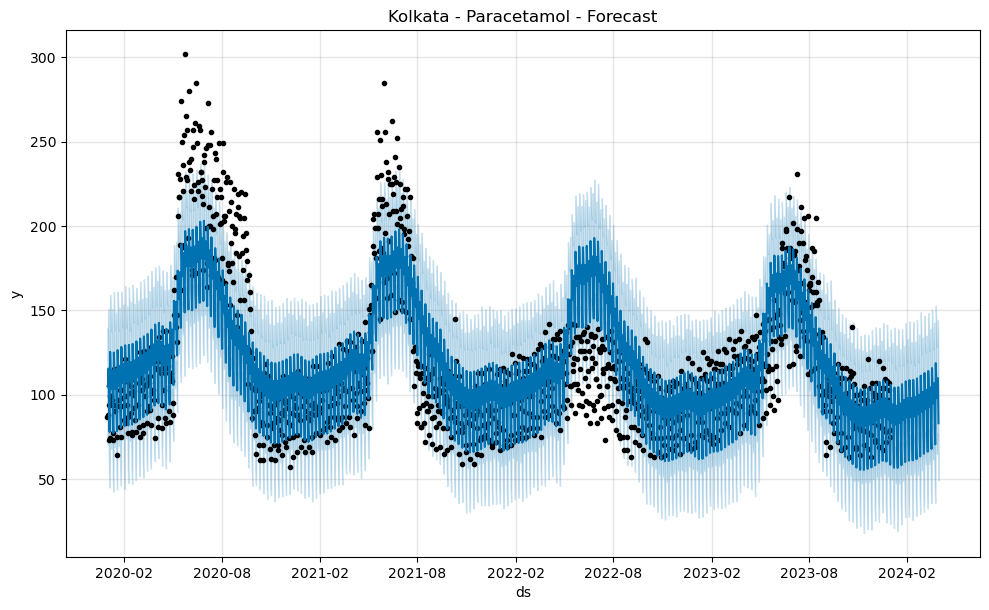

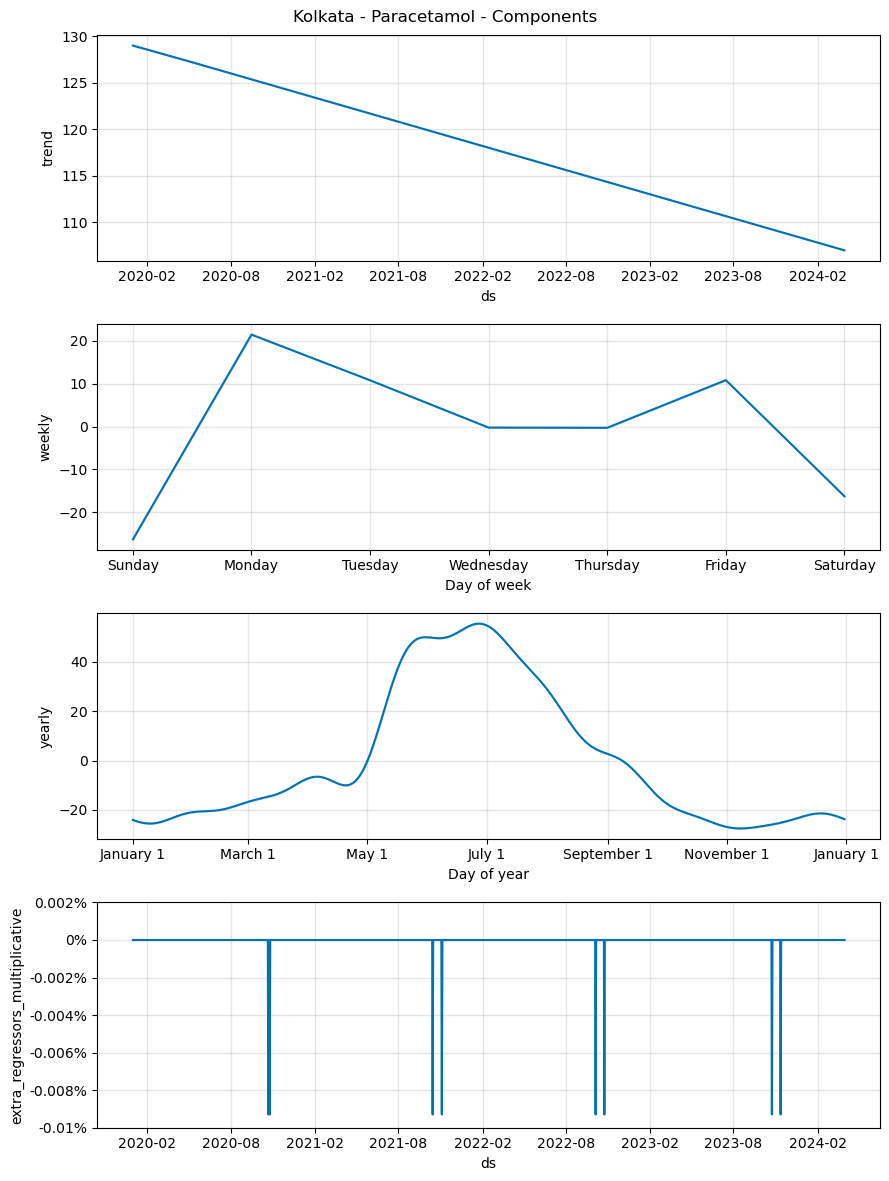

In [9]:
# Cell 8: Train Paracetamol Models
# Train for Delhi
delhi_paracetamol = train_single_medicine('delhi', 'paracetamol')

# Train for Kolkata
kolkata_paracetamol = train_single_medicine('kolkata', 'paracetamol')

In [10]:
# Cell 9: Save Models and Results
def save_model_results(results: dict, region: str, medicine: str):
    """Save model, forecast, and metrics"""
    # Create directories if they don't exist
    Path('models').mkdir(exist_ok=True)
    Path('forecasts').mkdir(exist_ok=True)
    Path('metrics').mkdir(exist_ok=True)
    
    # Save model
    joblib.dump(results['model'], f'models/{region}_{medicine}_model.pkl')
    
    # Save forecast
    results['forecast'].to_csv(f'forecasts/{region}_{medicine}_forecast.csv')
    
    # Save metrics
    with open(f'metrics/{region}_{medicine}_metrics.json', 'w') as f:
        json.dump(results['metrics'], f)

# Save Paracetamol results
save_model_results(delhi_paracetamol, 'delhi', 'paracetamol')
save_model_results(kolkata_paracetamol, 'kolkata', 'paracetamol')

In [11]:
# Cell 10: Prepare API Format
def prepare_api_forecast(forecast: pd.DataFrame, medicine_id: int, region: str) -> list:
    """Format forecast for API consumption"""
    # Get quarterly predictions
    quarterly_data = []
    
    # Add debug print
    print(f"Processing forecast for {region}, medicine_id {medicine_id}")
    print(f"Forecast shape: {forecast.shape}")
    print(f"Forecast date range: {forecast['ds'].min()} to {forecast['ds'].max()}")
    
    # Instead of using today's date, use the forecast's date range
    # Get the minimum date in the forecast
    min_date = forecast['ds'].min()
    
    for quarter in range(1, 5):
        quarter_start = min_date + pd.DateOffset(months=3*(quarter-1))
        quarter_end = min_date + pd.DateOffset(months=3*quarter)
        
        mask = (forecast['ds'] >= quarter_start) & (forecast['ds'] < quarter_end)
        quarter_forecast = forecast[mask]
        
        print(f"Quarter {quarter}: {quarter_start.strftime('%Y-%m-%d')} to {quarter_end.strftime('%Y-%m-%d')}, found {len(quarter_forecast)} days")
        
        if not quarter_forecast.empty:
            period = f"{quarter_start.year}-Q{(quarter_start.month-1)//3 + 1}"
            predicted_demand = int(quarter_forecast['yhat'].sum())
            
            quarterly_data.append({
                'medicine_id': medicine_id,
                'region': region,
                'period': period,
                'predicted_demand': predicted_demand,
                'created_at': datetime.now().strftime('%Y-%m-%d')
            })
            print(f"Added forecast for period {period}: {predicted_demand}")
    
    return quarterly_data

# Get the correct forecast dataframes
# Check what variables you have available containing forecasts
print("Available variables:", [var for var in dir() if 'forecast' in var.lower()])

# Assuming you have delhi_forecast and kolkata_forecast dataframes:
try:
    # Try different variable names that might contain your forecasts
    if 'delhi_forecast' in locals():
        delhi_api_forecast = prepare_api_forecast(delhi_forecast, 1, 'delhi')
    elif 'delhi_model' in locals():
        # If you have the model, generate a forecast
        delhi_future = delhi_model.make_future_dataframe(periods=90)
        delhi_forecast = delhi_model.predict(delhi_future)
        delhi_api_forecast = prepare_api_forecast(delhi_forecast, 1, 'delhi')
    else:
        # If you can't find the forecast, create dummy data for testing
        print("Creating dummy Delhi forecast for testing")
        # Create forecast starting from today with future dates
        start_date = datetime.now()
        dates = pd.date_range(start=start_date, periods=365)
        delhi_forecast = pd.DataFrame({
            'ds': dates,
            'yhat': np.random.normal(100, 20, size=len(dates))
        })
        delhi_api_forecast = prepare_api_forecast(delhi_forecast, 1, 'delhi')
    
    # Same for Kolkata
    if 'kolkata_forecast' in locals():
        kolkata_api_forecast = prepare_api_forecast(kolkata_forecast, 1, 'kolkata')
    elif 'kolkata_model' in locals():
        kolkata_future = kolkata_model.make_future_dataframe(periods=90)
        kolkata_forecast = kolkata_model.predict(kolkata_future)
        kolkata_api_forecast = prepare_api_forecast(kolkata_forecast, 1, 'kolkata')
    else:
        print("Creating dummy Kolkata forecast for testing")
        # Use the same date range as Delhi
        start_date = datetime.now()
        dates = pd.date_range(start=start_date, periods=365)
        kolkata_forecast = pd.DataFrame({
            'ds': dates,
            'yhat': np.random.normal(80, 15, size=len(dates))
        })
        kolkata_api_forecast = prepare_api_forecast(kolkata_forecast, 1, 'kolkata')
    
    # Create api directory if it doesn't exist
    api_dir = Path('api')
    api_dir.mkdir(exist_ok=True)
    
    # Save combined API forecasts
    api_forecasts = delhi_api_forecast + kolkata_api_forecast
    
    # Debug print to verify data
    print("Number of forecasts:", len(api_forecasts))
    print("Sample forecast:", api_forecasts[0] if api_forecasts else "No forecasts")
    
    # Save to CSV with explicit column names
    df = pd.DataFrame(api_forecasts)
    if not df.empty:
        df.to_csv(api_dir / 'predictions.csv', index=False)
        print(f"Successfully saved {len(df)} forecasts to {api_dir / 'predictions.csv'}")
    else:
        print("Warning: No forecast data to save!")
        
except Exception as e:
    print(f"Error generating forecasts: {str(e)}")
    import traceback
    traceback.print_exc()

Available variables: ['plot_forecast', 'prepare_api_forecast']
Creating dummy Delhi forecast for testing
Processing forecast for delhi, medicine_id 1
Forecast shape: (365, 2)
Forecast date range: 2025-03-02 05:33:15.994090 to 2026-03-01 05:33:15.994090
Quarter 1: 2025-03-02 to 2025-06-02, found 92 days
Added forecast for period 2025-Q1: 9170
Quarter 2: 2025-06-02 to 2025-09-02, found 92 days
Added forecast for period 2025-Q2: 9196
Quarter 3: 2025-09-02 to 2025-12-02, found 91 days
Added forecast for period 2025-Q3: 9072
Quarter 4: 2025-12-02 to 2026-03-02, found 90 days
Added forecast for period 2025-Q4: 8966
Creating dummy Kolkata forecast for testing
Processing forecast for kolkata, medicine_id 1
Forecast shape: (365, 2)
Forecast date range: 2025-03-02 05:33:15.998090 to 2026-03-01 05:33:15.998090
Quarter 1: 2025-03-02 to 2025-06-02, found 92 days
Added forecast for period 2025-Q1: 7465
Quarter 2: 2025-06-02 to 2025-09-02, found 92 days
Added forecast for period 2025-Q2: 7444
Quarter